In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from prophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
std=StandardScaler()

A1. McKinsey에 따르면 세계 경제 성장의 주요 원동력 중 하나인 가계소득이 30~50% 감소하였다. 각국의 봉쇄 조치로 공중 시설과 상점 등이 문을 닫고 항공 여행이 중단되어 실내에서 소비하는 TV 시청이나 비디오 게임 산업 외의 대부분의 산업에서 지출이 감소하였다. 하루 빨리 팬데믹 사태를 종결시키기 위해서 데이터를 통해 코로나 감염 실태를 분석하고 적절한 대응 방안이 필요하다.


A2. 
Action 1: 데이터분석 및 데이터 시각화를 통한 코로나 데이터 탐색 (What)


*  데이터 타입, 사이즈, 결측값 분석 및 핸들링
*  데이터 특징 분석: 감염자수, 사망자수, 회복한 사람수(회복자수)
*  일단위, 주단위 등 시계열 데이터 분석 및 시각화


Action 2: 분석한 데이터를 통해서 치명율과 회복율을 기반으로 국가별 클러스터링 수행 (Where)


*  K-means Cluster의 Elbow method를 통해 적절한 k 값을 찾겠다.
*  적잘한 k에 기반한 클러스터 국가들을 확인하고 분석한다.
*  클러스터별로 특성을 정의하고 클러스터 특성에 맞춘 대응 방안을 마련한다
*  클러스터별로 이하의 Action들을 수행한다.


Action 3: 클러스터별 다양한 감염자 예측 모델링을 통한 백신 수요 예측 (How, When)
다른 양상을 띄는 3가지의 클러스터별 감염자 예측 모델링을 다양한 방법론을 통해서 예측하고 성능을 비교하도록 하겠다. 


*   학습/테스트 데이터는 0.95, 0.05 비율로 나누도록 하겠다.
*   Linear, Polynomial, SVM, Holt, Holt's Winter, Auto Regression, Moving Average, ARIMA, SARIMA, Prophet의 성능을 비교하겠다.
*   성능 비교 Metric은 Root Mean Squared Error를 사용하겠다.


Action 4: 모델별 확진자수/감염자수 예측 기반 백신 배포 비율 산정
학습된 다양한 모델을 통해 예상되는 감염자수를 추정하고 추정된 확진자수/감염자에 맞게 백신 배포 비율을 산정한다. 마지막 단에 Softmax Function을 활용하여 클러스터 단위로 백신을 배포하는 방안을 수행토록 하겠다. 조금 더 세분한 배포를 위해서 클러스터 단위가 아닌 국가 단위의 감염자수 모델링 및 비교를 수행할 수 있으나 본 과제에서는 데모 차원에서 클러스터 단위로 아이디어 POC로 진행하도록 하겠다.

In [ ]:
covid = pd.read_csv('input/covid_19_data.csv')
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
print(f"covid shape: {covid.shape}")

covid shape: (98252, 8)


In [ ]:
print(f"null values: {covid.isnull().sum()}")

null values: SNo                    0
ObservationDate        0
Province/State     31153
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64


In [ ]:
print(f"null rate: {covid.isnull().sum()/covid.shape[0]}")

null rate: SNo                0.000000
ObservationDate    0.000000
Province/State     0.317072
Country/Region     0.000000
Last Update        0.000000
Confirmed          0.000000
Deaths             0.000000
Recovered          0.000000
dtype: float64


In [ ]:
print(f"dtypes: {covid.dtypes}")

dtypes: SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [ ]:
covid.drop(["SNo"], 1, inplace=True)

In [ ]:
covid["ObservationDate"] = pd.to_datetime(covid["ObservationDate"])
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98252 entries, 0 to 98251
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ObservationDate  98252 non-null  datetime64[ns]
 1   Province/State   67099 non-null  object        
 2   Country/Region   98252 non-null  object        
 3   Last Update      98252 non-null  object        
 4   Confirmed        98252 non-null  float64       
 5   Deaths           98252 non-null  float64       
 6   Recovered        98252 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 5.2+ MB


In [ ]:
covid["ObservationDate"].head()

0   2020-01-22
1   2020-01-22
2   2020-01-22
3   2020-01-22
4   2020-01-22
Name: ObservationDate, dtype: datetime64[ns]

In [ ]:
covid["ObservationDate"].tail()

98247   2020-08-29
98248   2020-08-29
98249   2020-08-29
98250   2020-08-29
98251   2020-08-29
Name: ObservationDate, dtype: datetime64[ns]

In [ ]:
grouped_country = covid.groupby(["Country/Region", "ObservationDate"]).agg({"Confirmed": "sum", "Recovered": "sum", "Deaths": "sum"})
grouped_country.head()

Confirmed  Recovered  Deaths
Country/Region  ObservationDate                              
 Azerbaijan     2020-02-28             1.0        0.0     0.0
('St. Martin',) 2020-03-10             2.0        0.0     0.0
Afghanistan     2020-02-24             1.0        0.0     0.0
                2020-02-25             1.0        0.0     0.0
                2020-02-26             1.0        0.0     0.0

In [ ]:
grouped_country["Active Cases"] = grouped_country["Confirmed"] - grouped_country["Recovered"] - grouped_country["Deaths"]
grouped_country["log_confirmed"] = np.log(grouped_country["Confirmed"])
grouped_country["log_active"] = np.log(grouped_country["Active Cases"])

In [ ]:
grouped_country.head()

Confirmed  Recovered  Deaths  Active Cases  \
Country/Region  ObservationDate                                               
 Azerbaijan     2020-02-28             1.0        0.0     0.0           1.0   
('St. Martin',) 2020-03-10             2.0        0.0     0.0           2.0   
Afghanistan     2020-02-24             1.0        0.0     0.0           1.0   
                2020-02-25             1.0        0.0     0.0           1.0   
                2020-02-26             1.0        0.0     0.0           1.0   

                                 log_confirmed  log_active  
Country/Region  ObservationDate                             
 Azerbaijan     2020-02-28            0.000000    0.000000  
('St. Martin',) 2020-03-10            0.693147    0.693147  
Afghanistan     2020-02-24            0.000000    0.000000  
                2020-02-25            0.000000    0.000000  
                2020-02-26            0.000000    0.000000

In [ ]:
covid.head()
datewise_Brazil = covid.groupby(["ObservationDate"]).agg({"Confirmed": "sum", "Recovered": "sum", "Deaths": "sum"})

In [ ]:
datewise = covid.groupby(["ObservationDate"]).agg({"Confirmed": "sum", "Recovered": "sum", "Deaths": "sum"})
datewise["Days Since"] = datewise.index - datewise.index.min()
datewise.head(10)

,Confirmed,Recovered,Deaths,Days Since
ObservationDate,,,,
2020-01-22,555.0,28.0,17.0,0 days
2020-01-23,653.0,30.0,18.0,1 days
2020-01-24,941.0,36.0,26.0,2 days
2020-01-25,1438.0,39.0,42.0,3 days
2020-01-26,2118.0,52.0,56.0,4 days
2020-01-27,2927.0,61.0,82.0,5 days
2020-01-28,5578.0,107.0,131.0,6 days
2020-01-29,6165.0,126.0,133.0,7 days
2020-01-30,8235.0,143.0,171.0,8 days


Action 1. 데이터 분석


*   데이터 건수: 98252
*   데이터 
  *  SNo: int64, 시리얼 넘버, 미사용으로 삭제
  *  ObservationDate: object, 관측일, datetime으로 변환, 결측값 없음
  *  Province/State: 시도, object, 결측값 31.7% 
  *  Country/Region: 국가, 결측값 없음
  *  Last Update: 수정일, 결측값 없음
  *  Confirmed: 확진자수/감염자수, 결측값 없음
  *  Deaths: 사망자수, 결측값 없음
  *  Recovered: 회복자수, 결측값 없음





In [ ]:
print("추가 데이터분석 Information")
print(f"Total number of countries with Disease Spread: {len(covid['Country/Region'].unique())}")
print(f"Total number of Confirmed Cases around the World: {datewise['Confirmed'].iloc[-1]}")
print(f"Total number of Recovered Cases around the World: {datewise['Recovered'].iloc[-1]}")
print(f"Total number of Deaths Cases around the World: {datewise['Deaths'].iloc[-1]}")
print(f"Total number of Active Cases around the World: {datewise['Confirmed'].iloc[-1] - datewise['Recovered'].iloc[-1] - datewise['Deaths'].iloc[-1]}")
print(f"Total number of Closed Cases around the World: {datewise['Recovered'].iloc[-1] + datewise['Deaths'].iloc[-1]}")
print(f"Approximate number of Confirmed Cases per Day around the World: {np.round(datewise['Confirmed'].iloc[-1]/datewise.shape[0])}")
print(f"Approximate number of Recovered Cases per Day around the World: {np.round(datewise['Recovered'].iloc[-1]/datewise.shape[0])}")
print(f"Approximate number of Deaths Cases per Day around the World: {np.round(datewise['Deaths'].iloc[-1]/datewise.shape[0])}")
print(f"Number of Confirmed Cases in last 24 hours: {datewise['Confirmed'].iloc[-1] - datewise['Confirmed'].iloc[-2]}")
print(f"Number of Recovered Cases in last 24 hours: {datewise['Recovered'].iloc[-1] - datewise['Recovered'].iloc[-2]}")
print(f"Number of Death Cases in last 24 hours: {datewise['Deaths'].iloc[-1] - datewise['Deaths'].iloc[-2]}")

추가 데이터분석 Information
Total number of countries with Disease Spread: 223
Total number of Confirmed Cases around the World: 24996456.0
Total number of Recovered Cases around the World: 16409757.0
Total number of Deaths Cases around the World: 842499.0
Total number of Active Cases around the World: 7744200.0
Total number of Closed Cases around the World: 17252256.0
Approximate number of Confirmed Cases per Day around the World: 113106.0
Approximate number of Recovered Cases per Day around the World: 74252.0
Approximate number of Deaths Cases per Day around the World: 3812.0
Number of Confirmed Cases in last 24 hours: 262008.0
Number of Recovered Cases in last 24 hours: 211592.0
Number of Death Cases in last 24 hours: 5375.0


In [ ]:
fig = px.bar(x=datewise.index, y=datewise["Confirmed"] - datewise["Recovered"] - datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases", xaxis_title="Date", yaxis_title="Number of Cases")
fig.show()

Active Cases = # of Confirmed Case - # of Recovered Cases - # of Death Cases. 


Active Cases가 증가한다면 확진자수가 증가세라는 것을 확인할 수 있다.

In [ ]:
fig = px.bar(x=datewise.index, y=datewise['Recovered'] + datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases", xaxis_title="Date", yaxis_title="Number of Cases")
fig.show()

Closed Cases = # of Recovered Cases + # of Death Cases. 


Closed Cases가 증가한다는 것은 코로나 감염 후 회복한 사람들이나 사망자가 점차 증가한다는 것을 나타낸다.

In [ ]:
datewise["WeekOfYear"] = datewise.index.weekofyear
datewise

,Confirmed,Recovered,Deaths,Days Since,WeekOfYear
ObservationDate,,,,,
2020-01-22,555.0,28.0,17.0,0 days,4
2020-01-23,653.0,30.0,18.0,1 days,4
2020-01-24,941.0,36.0,26.0,2 days,4
2020-01-25,1438.0,39.0,42.0,3 days,4
2020-01-26,2118.0,52.0,56.0,4 days,4
...,...,...,...,...,...
2020-08-25,23889150.0,15570191.0,819414.0,216 days,35
2020-08-26,24176836.0,15794441.0,825696.0,217 days,35
2020-08-27,24452629.0,15997281.0,831586.0,218 days,35


In [ ]:
week_num = []
weekwise_confirmed = []
weekwise_recovered = []
weekwise_deaths = []

w = 1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"] == i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"] == i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"] == i]["Deaths"].iloc[-1])
    week_num.append(w)
    w += 1

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed, mode='lines+markers', name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered, mode='lines+markers', name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths, mode='lines+markers', name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases", xaxis_title="Week Number", yaxis_title="Number of Cases", legend=dict(x=0, y=1, traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

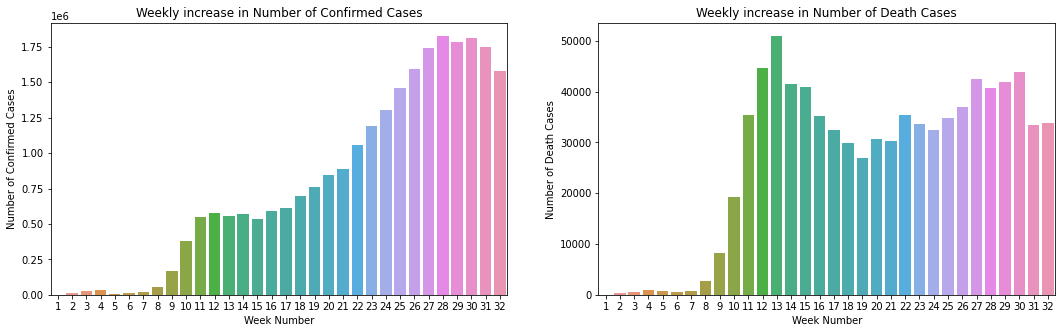

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
sns.barplot(x=week_num, y=pd.Series(weekwise_confirmed).diff().fillna(0), ax=ax1)
sns.barplot(x=week_num, y=pd.Series(weekwise_deaths).diff().fillna(0), ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

주단위 확진자수, 사망자수, 회복자수를 살펴본 결과이다.


14주 전후로 사망자수가 크게 줄어든 것으로 보아 사회적 거리두기 등으로 사망자수를 관리한 것으로 추측된다. 이런 추세는 19주까지 이어지다 새로운 감염자수의 속출로 다시 사망자 수가 증가하는 것을 확인할 수 있다. 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise['Confirmed'], mode='lines+markers', name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise['Recovered'], mode='lines+markers', name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise['Deaths'], mode='lines+markers', name='Death Cases'))
fig.update_layout(title="Growth of different types of cases", xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
datewise["Mortality Rate"] = (datewise["Deaths"]/datewise["Confirmed"]) * 100
datewise["Recovery Rate"] = (datewise["Recovered"]/datewise["Confirmed"]) * 100
datewise["Active Cases"] = datewise["Confirmed"] - datewise["Recovered"] - datewise["Deaths"]
datewise["Closed Cases"] = datewise["Recovered"] + datewise["Deaths"]

print("Average Mortality Rate", datewise["Mortality Rate"].mean())
print("Median Mortality Rate", datewise["Mortality Rate"].median())
print("Average Recovery Rate", datewise["Recovery Rate"].mean())
print("Median Mortality Rate", datewise["Recovery Rate"].median())

fig = make_subplots(rows=2, cols=1, subplot_titles=("Recovery Rate", "Mortality Rate"))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100, name="Recovery Rate"), row=1, col=1)
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100, name="Mortality Rate"), row=2, col=1)
fig.update_layout(height=1000, legend=dict(x=-0.1, y=1.2, traceorder="normal"))
fig.update_xaxes(title_text="Date", row = 1, col = 1)
fig.update_yaxes(title_text="Recovery Rate", row = 1, col = 1)
fig.update_xaxes(title_text="Date", row = 1, col = 2)
fig.update_yaxes(title_text="Mortality Rate", row = 1, col = 2)
fig.show()

Average Mortality Rate 4.634104124836859
Median Mortality Rate 4.4083056727246195
Average Recovery Rate 39.16083883932324
Median Mortality Rate 42.09012917192399


Mortality rate = (# of Death Cases / # of Confirmed Cases) x 100


Recovery Rate= (# of Recoverd Cases / # of Confirmed Cases) x 100


사망율의 경우 2020년 5월을 지나 점차 줄어드는 추세를 확인할 수 있다. 회복율 또한 2020년 4월 이후로 지속적으로 증가하고 있다.

In [ ]:
print("Average increase in number of Confirmed Cases every day: ", np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ", np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ", np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig = go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0), mode="lines+markers", name="Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0), mode="lines+markers", name="Recovered Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0), mode="lines+markers", name="Deaths Cases"))
fig.update_layout(title="Daily increase in different types of Cases", xaxis_title="Date", yaxis_title="Number of Cases", legend=dict(x=0, y=1, traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  113104.0
Average increase in number of Recovered Cases every day:  74252.0
Average increase in number of Deaths Cases every day:  3812.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(), mode="lines+markers", name="Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(), mode="lines+markers", name="Recovered Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(), mode="lines+markers", name="Deaths Cases"))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases", xaxis_title="Date", yaxis_title="Number of Cases", legend=dict(x=0, y=1, traceorder="normal"))
fig.show()

In [ ]:
print("Average growth factor of number of Confirmed Cases: ", (datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ", (datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ", (datewise["Recovered"]/datewise["Recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ", (datewise["Recovered"]/datewise["Recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ", (datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ", (datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig = go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(), mode="lines", name="Growth Factor of Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"]/datewise["Recovered"].shift(), mode="lines", name="Growth Factor of Recovered Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(), mode="lines", name="Growth Factor of Deaths Cases"))
fig.update_layout(title="Datwwise Growth Factor of different types of cases.", xaxis_title="Date", yaxis_title="Growth Factor", legend=dict(x=0, y=-0.4, traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.0534037322997345
Median growth factor of number of Confirmed Cases:  1.0202013845748947
Average growth factor of number of Recovered Cases:  1.0659417596633376
Median growth factor of number of Recovered Cases:  1.0305531800502579
Average growth factor of number of Death Cases:  1.0534793524039714
Median growth factor of number of Death Cases:  1.0153996847560398


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index,
                         y=(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]+datewise["Deaths"])/(datewise["Recovered"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Growth Factor는 현재값과 이전값 간의 배율로 1보다 클 경우 지수적으로 증가하고 1보다 작을 경우 지수적으로 감소한다고 볼 수 있다. 1일 경우 평행 상태를 유지한다고 보면 된다.


2020년 3월 이전에는 모든 지표에 대해서 Growth Factor가 상당히 큰 값으로 요동치더니 2020년 5월 이후로 점차 1에 가까이 수렴하는 것을 확인할 수 있다.

In [ ]:
c = 560
double_days = []
C = []
while(1):
    double_days.append(datewise[datewise["Confirmed"] <= c].iloc[[-1]]["Days Since"][0])
    C.append(c)
    c *= 2
    if c < datewise["Confirmed"].max():
        continue
    else:
        break

In [ ]:
doubling_rate=pd.DataFrame(list(zip(C,double_days)),columns=["No. of cases","Days since first Case"])
doubling_rate["Number of days for doubling"]=doubling_rate["Days since first Case"].diff().fillna(doubling_rate["Days since first Case"])
doubling_rate

,No. of cases,Days since first Case,Number of days for doubling
0,560,0 days,0 days
1,1120,2 days,2 days
2,2240,4 days,2 days
3,4480,5 days,1 days
4,8960,8 days,3 days
5,17920,11 days,3 days
6,35840,16 days,5 days
7,71680,25 days,9 days
8,143360,50 days,25 days
9,286720,58 days,8 days


In [ ]:
c1=100000
days_300k=[]
C1=[]
while(1):
    days_300k.append(datewise[datewise["Confirmed"]<=c1].iloc[[-1]]["Days Since"][0])
    C1.append(c1)
    c1=c1+300000
    if(c1<datewise["Confirmed"].max()):
        continue
    else:
        break

In [ ]:
rate_300k=pd.DataFrame(list(zip(C1,days_300k)),columns=["No. of Cases","Days Since first Case"])
rate_300k["Days requried for rise of 300K"]=rate_300k["Days Since first Case"].diff().fillna(rate_300k["Days Since first Case"].iloc[[0]][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=rate_300k["No. of Cases"], y=rate_300k["Days requried for rise of 300K"].dt.days,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.update_layout(title="Number of Days required for increase in number of cases by 300K",
                 xaxis_title="Number of Cases",yaxis_title="Number of Days")
fig.show()

300K의 추가적인 감염자수가 증가하는 속도가 점차 짧아지는 것을 보아 많아지는 감염자가 더욱 많은 감염자를 재생산하는 것을 확인할 수 있다.


반면 확진자수가 2배로 증가하는데 걸리는 시간은 짧아지다가 다시 길어지는 것을 확인할 수 있는데 이는 증가율 차원에서는 점차 호전된다고 볼 수 있으며 그만큼 사회적 거리두기 등이 효과를 나타낸다고도 볼 수 있다.

In [ ]:
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

In [ ]:
countrywise.dropna(subset=['Mortality', 'Recovery'], how='all', inplace=True)

In [ ]:
countrywise

,Confirmed,Recovered,Deaths,Mortality,Recovery
Country/Region,,,,,
US,5961094.0,2140614.0,182761.0,3.065897,35.909751
Brazil,3846153.0,3202185.0,120262.0,3.126813,83.256828
India,3542733.0,2713933.0,63498.0,1.792345,76.605632
Russia,982573.0,802365.0,16977.0,1.727811,81.659582
Peru,629961.0,438017.0,28471.0,4.519486,69.530812
...,...,...,...,...,...
Dominica,20.0,18.0,0.0,0.000000,90.000000
Saint Kitts and Nevis,17.0,17.0,0.0,0.000000,100.000000
Holy See,12.0,12.0,0.0,0.000000,100.000000


In [ ]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [ ]:
country_last_24_confirmed=[]
country_last_24_recovered=[]
country_last_24_deaths=[]
for country in countrywise.index:
    country_last_24_confirmed.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Confirmed"])
    country_last_24_recovered.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Recovered"])
    country_last_24_deaths.append((grouped_country.loc[country].iloc[-1]-grouped_country.loc[country].iloc[-2])["Deaths"])

In [ ]:
Last_24_Hours_country=pd.DataFrame(list(zip(countrywise.index,country_last_24_confirmed,country_last_24_recovered,country_last_24_deaths)),
                                   columns=["Country Name","Last 24 Hours Confirmed","Last 24 Hours Recovered","Last 24 Hours Deaths"])

Text(0.5, 1.0, 'Top 15 Countries with Highest Number of Death Cases in Last 24 Hours')

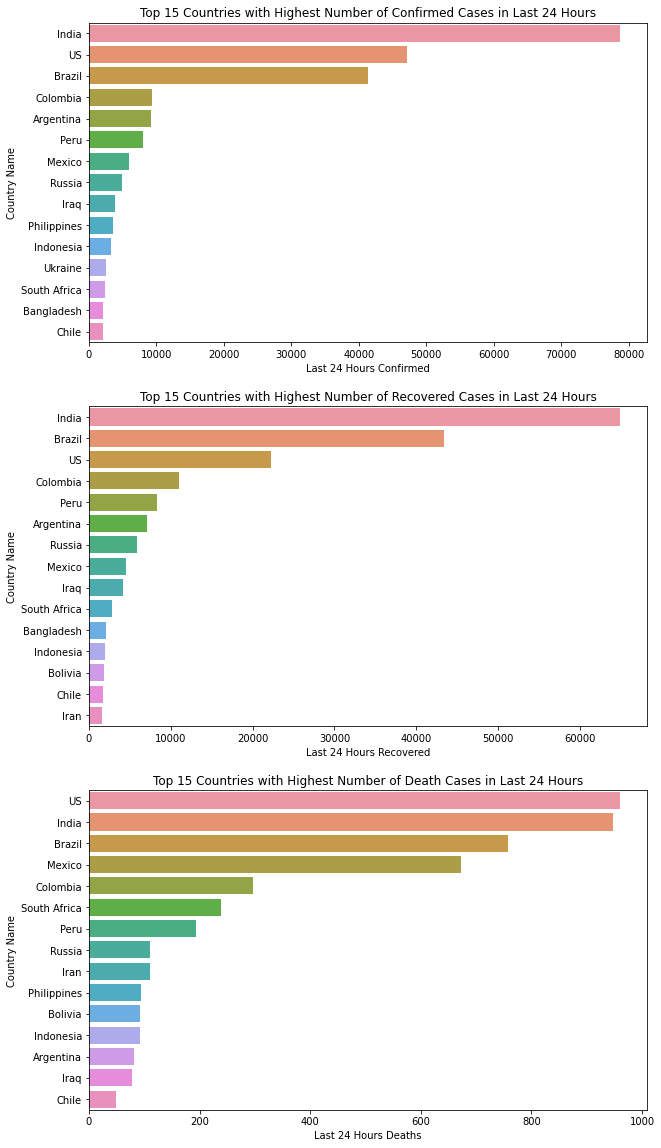

In [ ]:
Top_15_Confirmed_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Confirmed"],ascending=False).head(15)
Top_15_Recoverd_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Recovered"],ascending=False).head(15)
Top_15_Deaths_24hr=Last_24_Hours_country.sort_values(["Last 24 Hours Deaths"],ascending=False).head(15)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,20))
sns.barplot(x=Top_15_Confirmed_24hr["Last 24 Hours Confirmed"],y=Top_15_Confirmed_24hr["Country Name"],ax=ax1)
ax1.set_title("Top 15 Countries with Highest Number of Confirmed Cases in Last 24 Hours")
sns.barplot(x=Top_15_Recoverd_24hr["Last 24 Hours Recovered"],y=Top_15_Recoverd_24hr["Country Name"],ax=ax2)
ax2.set_title("Top 15 Countries with Highest Number of Recovered Cases in Last 24 Hours")
sns.barplot(x=Top_15_Deaths_24hr["Last 24 Hours Deaths"],y=Top_15_Deaths_24hr["Country Name"],ax=ax3)
ax3.set_title("Top 15 Countries with Highest Number of Death Cases in Last 24 Hours")

In [ ]:
Last_24_Hours_country["Proportion of Confirmed"]=(Last_24_Hours_country["Last 24 Hours Confirmed"]/(datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Recovered"]=(Last_24_Hours_country["Last 24 Hours Recovered"]/(datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2]))*100
Last_24_Hours_country["Proportion of Deaths"]=(Last_24_Hours_country["Last 24 Hours Deaths"]/(datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2]))*100

In [ ]:
Last_24_Hours_country[["Country Name","Proportion of Confirmed","Proportion of Recovered","Proportion of Deaths"]].sort_values(["Proportion of Confirmed"],ascending=False).style.background_gradient(cmap="Reds")

,Country Name,Proportion of Confirmed,Proportion of Recovered,Proportion of Deaths
2,India,30.060533,30.688778,17.637209
0,US,17.996779,10.514103,17.879070
1,Brazil,15.781961,20.512118,14.102326
6,Colombia,3.584623,5.176944,5.525581
10,Argentina,3.522793,3.334247,1.525581
4,Peru,3.039602,3.948637,3.609302
7,Mexico,2.280083,2.132878,12.520930
3,Russia,1.848417,2.772789,2.065116
20,Iraq,1.463314,1.959431,1.432558
21,Philippines,1.369042,0.296325,1.748837


Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

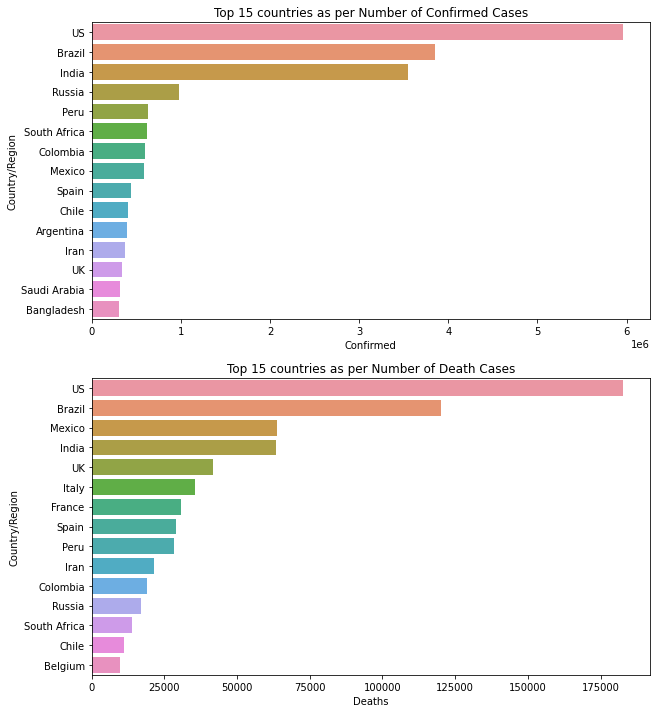

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

Text(0.5, 1.0, 'Top 15 countries as per Number of Death Cases')

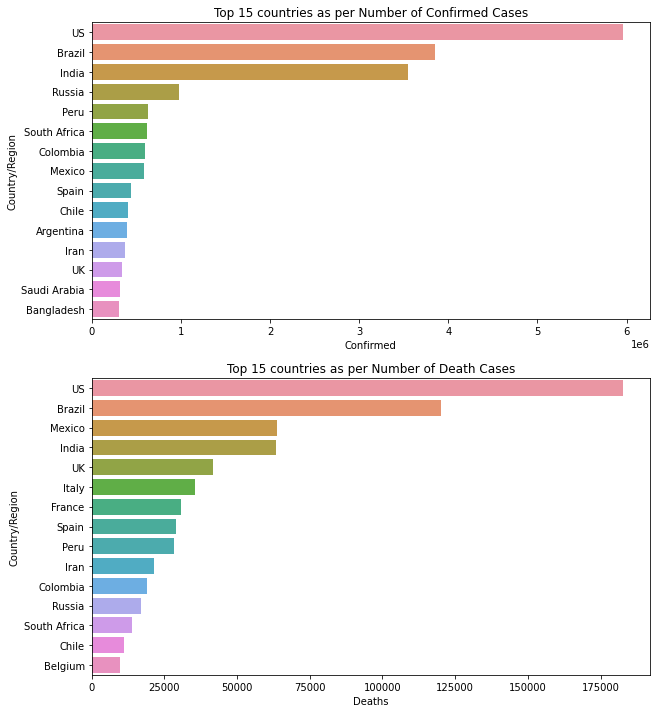

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,12))
top_15_confirmed=countrywise.sort_values(["Confirmed"],ascending=False).head(15)
top_15_deaths=countrywise.sort_values(["Deaths"],ascending=False).head(15)
sns.barplot(x=top_15_confirmed["Confirmed"],y=top_15_confirmed.index,ax=ax1)
ax1.set_title("Top 15 countries as per Number of Confirmed Cases")
sns.barplot(x=top_15_deaths["Deaths"],y=top_15_deaths.index,ax=ax2)
ax2.set_title("Top 15 countries as per Number of Death Cases")

In [ ]:
no_recovered_countries=countrywise[(countrywise["Recovered"]==0)][["Confirmed","Deaths"]]
no_recovered_countries["Mortality Rate"]=(no_recovered_countries["Deaths"]/no_recovered_countries["Confirmed"])*100
no_recovered_countries=no_recovered_countries[no_recovered_countries["Mortality Rate"]>0].sort_values(["Mortality Rate"],ascending=False)
no_recovered_countries.style.background_gradient('Reds')

,Confirmed,Deaths,Mortality Rate
Country/Region,,,
MS Zaandam,9.000000,2.000000,22.222222
Sweden,83958.000000,5821.000000,6.933229
Serbia,31282.000000,710.000000,2.269676


In [ ]:
no_recovered_countries=countrywise[(countrywise["Recovered"]==0)][["Confirmed","Deaths"]]
no_recovered_countries["Mortality Rate"]=(no_recovered_countries["Deaths"]/no_recovered_countries["Confirmed"])*100
no_recovered_countries=no_recovered_countries[no_recovered_countries["Mortality Rate"]>0].sort_values(["Mortality Rate"],ascending=False)
no_recovered_countries.style.background_gradient('Reds')

,Confirmed,Deaths,Mortality Rate
Country/Region,,,
MS Zaandam,9.000000,2.000000,22.222222
Sweden,83958.000000,5821.000000,6.933229
Serbia,31282.000000,710.000000,2.269676


Text(0.5, 1.0, 'Top 15 Countries with Most Number of Closed Cases')

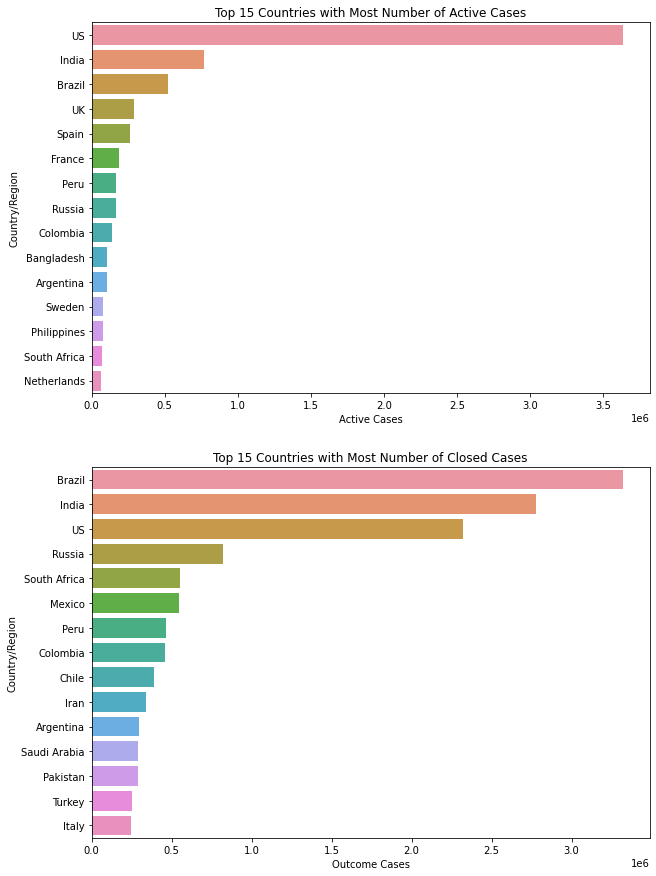

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Active Cases"]=(countrywise["Confirmed"]-countrywise["Recovered"]-countrywise["Deaths"])
countrywise["Outcome Cases"]=(countrywise["Recovered"]+countrywise["Deaths"])
top_15_active=countrywise.sort_values(["Active Cases"],ascending=False).head(15)
top_15_outcome=countrywise.sort_values(["Outcome Cases"],ascending=False).head(15)
sns.barplot(x=top_15_active["Active Cases"],y=top_15_active.index,ax=ax1)
sns.barplot(x=top_15_outcome["Outcome Cases"],y=top_15_outcome.index,ax=ax2)
ax1.set_title("Top 15 Countries with Most Number of Active Cases")
ax2.set_title("Top 15 Countries with Most Number of Closed Cases")

In [ ]:
country_date=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
confirm_rate=[]
for country in countrywise.index:
    days=country_date.loc[country].shape[0]
    confirm_rate.append((countrywise.loc[country]["Confirmed"])/days)
countrywise["Confirm Cases/Day"]=confirm_rate

Text(0.5, 1.0, 'Top 15 countries as per Lowest Confirmed Cases per Day having more than 1000 Confirmed Cases')

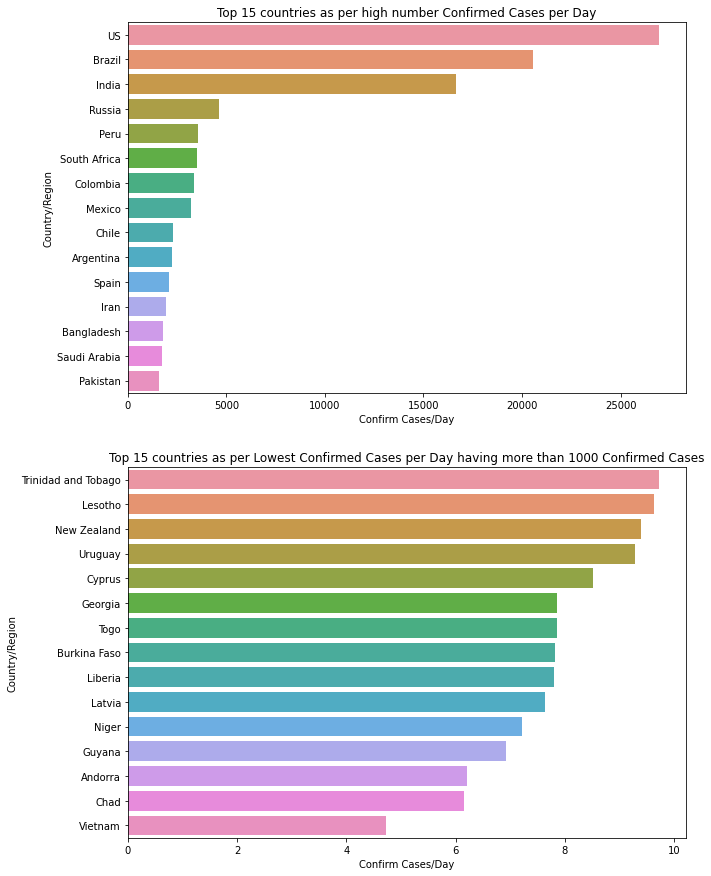

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
top_15_ccpd=countrywise.sort_values(["Confirm Cases/Day"],ascending=False).head(15)
sns.barplot(y=top_15_ccpd.index,x=top_15_ccpd["Confirm Cases/Day"],ax=ax1)
ax1.set_title("Top 15 countries as per high number Confirmed Cases per Day")
bottom_15_ccpd=countrywise[countrywise["Confirmed"]>1000].sort_values(["Confirm Cases/Day"],ascending=False).tail(15)
sns.barplot(y=bottom_15_ccpd.index,x=bottom_15_ccpd["Confirm Cases/Day"],ax=ax2)
ax2.set_title("Top 15 countries as per Lowest Confirmed Cases per Day having more than 1000 Confirmed Cases")

Mean Survival Probability across all countries 97.1141462840676
Median Survival Probability across all countries 97.91743252359151
Mean Death Probability across all countries 2.8858537159323987
Median Death Probability across all countries 2.082567476408485


Text(0.5, 1.0, 'Bottom 15 Countries as per Survival Probability')

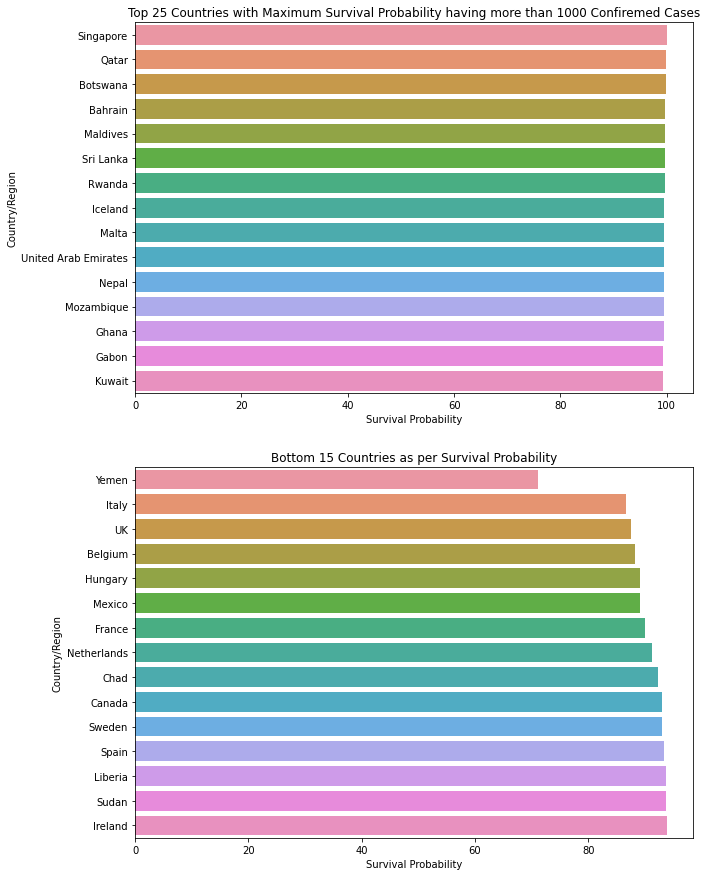

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,15))
countrywise["Survival Probability"]=(1-(countrywise["Deaths"]/countrywise["Confirmed"]))*100
top_25_survival=countrywise[countrywise["Confirmed"]>1000].sort_values(["Survival Probability"],ascending=False).head(15)
sns.barplot(x=top_25_survival["Survival Probability"],y=top_25_survival.index,ax=ax1)
ax1.set_title("Top 25 Countries with Maximum Survival Probability having more than 1000 Confiremed Cases")
print('Mean Survival Probability across all countries',countrywise["Survival Probability"].mean())
print('Median Survival Probability across all countries',countrywise["Survival Probability"].median())
print('Mean Death Probability across all countries',100-countrywise["Survival Probability"].mean())
print('Median Death Probability across all countries',100-countrywise["Survival Probability"].median())

Bottom_5_countries=countrywise[countrywise["Confirmed"]>100].sort_values(["Survival Probability"],ascending=True).head(15)
sns.barplot(x=Bottom_5_countries["Survival Probability"],y=Bottom_5_countries.index,ax=ax2)
plt.title("Bottom 15 Countries as per Survival Probability")

In [ ]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country]["log_confirmed"], y=grouped_country.loc[country]["log_active"],
                    mode='lines',name=country))
fig.update_layout(height=600,title="COVID-19 Journey of Top 15 Worst Affected Countries",
                 xaxis_title="Confirmed Cases (Logrithmic Scale)",yaxis_title="Active Cases (Logarithmic Scale)",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index, y=grouped_country.loc[country]["Confirmed"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index,
                             y=grouped_country.loc[country]["Deaths"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Death Cases",
                 xaxis_title="Date",yaxis_title="Death Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
for country in countrywise.head(10).index:
    fig.add_trace(go.Scatter(x=grouped_country.loc[country].index,
                             y=grouped_country.loc[country]["Deaths"].rolling(window=7).mean().diff(),
                    mode='lines',name=country))
fig.update_layout(height=600,title="7 Days Rolling Average of Daily increase of Death Cases",
                 xaxis_title="Date",yaxis_title="Death Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
X=countrywise[["Mortality", "Recovery"]]
X.dropna(inplace=True)
X=std.fit_transform(X)

In [ ]:
wcss=[]
sil=[]
for i in range(2,11):
    clf=KMeans(n_clusters=i,init='k-means++',random_state=42)
    clf.fit(X)
    labels=clf.labels_
    centroids=clf.cluster_centers_
    sil.append(silhouette_score(X, labels, metric='euclidean'))
    wcss.append(clf.inertia_)

Text(0.5, 1.0, 'Elbow Method')

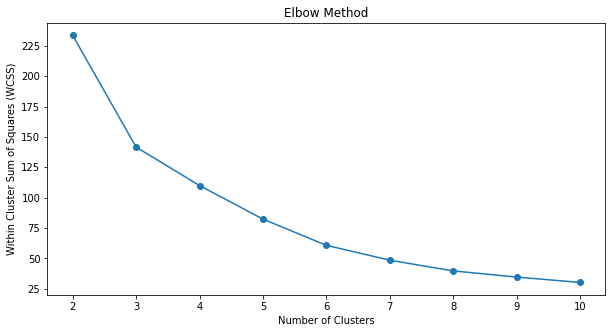

In [ ]:
x=np.arange(2,11)
plt.figure(figsize=(10,5))
plt.plot(x,wcss,marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

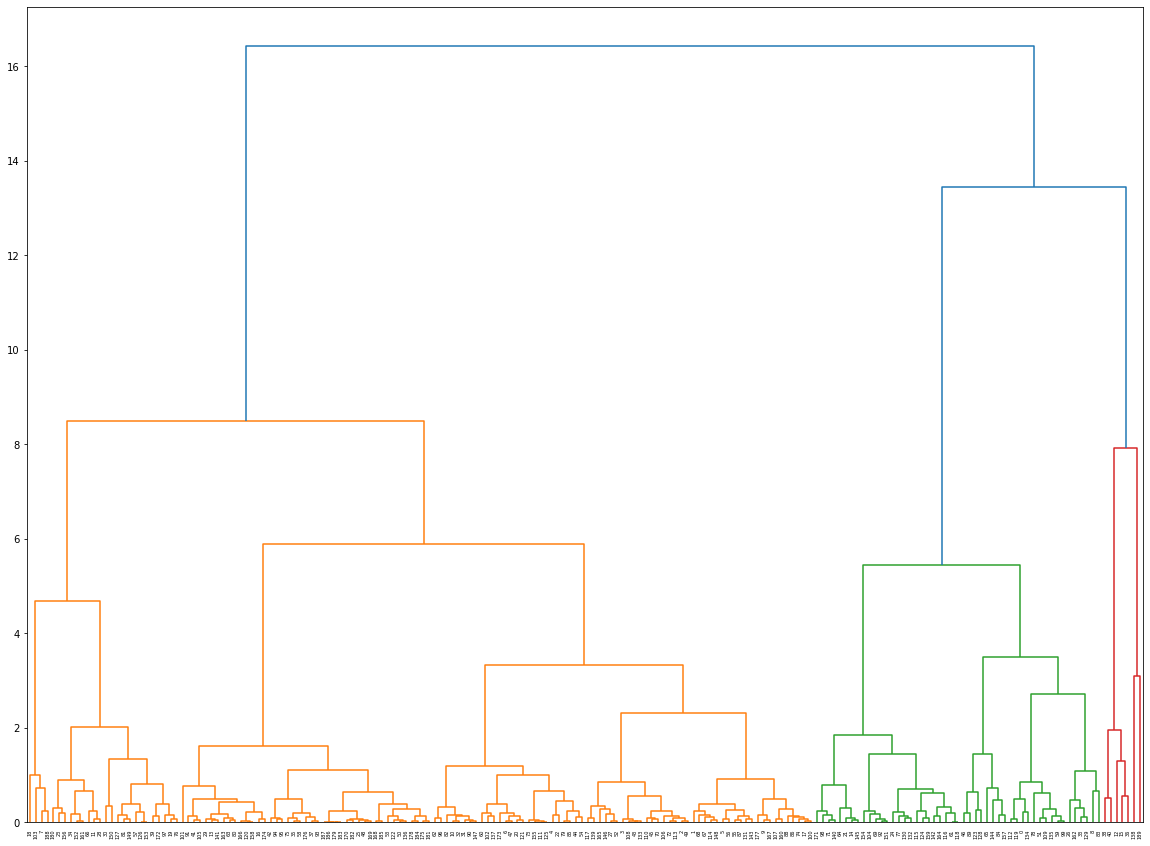

In [ ]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(20,15))
dendogram=sch.dendrogram(sch.linkage(X, method  = "ward"))

In [ ]:
clf_final=KMeans(n_clusters=3,init='k-means++',random_state=6)
clf_final.fit(X)

KMeans(n_clusters=3, random_state=6)

In [ ]:
countrywise["Clusters"]=clf_final.predict(X)

In [ ]:
cluster_summary=pd.concat([countrywise[countrywise["Clusters"]==1].head(15),countrywise[countrywise["Clusters"]==2].head(15),countrywise[countrywise["Clusters"]==0].head(15)])
cluster_summary.style.background_gradient(cmap='Reds').format("{:.2f}")

,Confirmed,Recovered,Deaths,Mortality,Recovery,Active Cases,Outcome Cases,Confirm Cases/Day,Survival Probability,Clusters
Country/Region,,,,,,,,,,
Mexico,591712.00,484283.00,63819.00,10.79,81.84,43610.00,548102.00,3198.44,89.21,1.00
UK,334916.00,1622.00,41585.00,12.42,0.48,291709.00,43207.00,1579.79,87.58,1.00
France,304947.00,86495.00,30601.00,10.03,28.36,187851.00,117096.00,1392.45,89.97,1.00
Italy,266853.00,208224.00,35473.00,13.29,78.03,23156.00,243697.00,1258.74,86.71,1.00
Belgium,84599.00,18403.00,9891.00,11.69,21.75,56305.00,28294.00,406.73,88.31,1.00
Netherlands,72128.00,986.00,6252.00,8.67,1.37,64890.00,7238.00,389.88,91.33,1.00
Hungary,5669.00,3759.00,614.00,10.83,66.31,1296.00,4373.00,31.67,89.17,1.00
Yemen,1946.00,1113.00,563.00,28.93,57.19,270.00,1676.00,13.70,71.07,1.00
Western Sahara,10.00,8.00,1.00,10.00,80.00,1.00,9.00,0.07,90.00,1.00


In [ ]:
print("Avergae Mortality Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 0: ",countrywise[countrywise["Clusters"]==0]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 1: ",countrywise[countrywise["Clusters"]==1]["Recovery"].mean())
print("Avergae Mortality Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Mortality"].mean())
print("Avergae Recovery Rate of Cluster 2: ",countrywise[countrywise["Clusters"]==2]["Recovery"].mean())

Avergae Mortality Rate of Cluster 0:  2.2463194361559777
Avergae Recovery Rate of Cluster 0:  83.75183966895968
Avergae Mortality Rate of Cluster 1:  13.887372332715879
Avergae Recovery Rate of Cluster 1:  41.534456148992625
Avergae Mortality Rate of Cluster 2:  2.3649469755029395
Avergae Recovery Rate of Cluster 2:  39.4954479457303


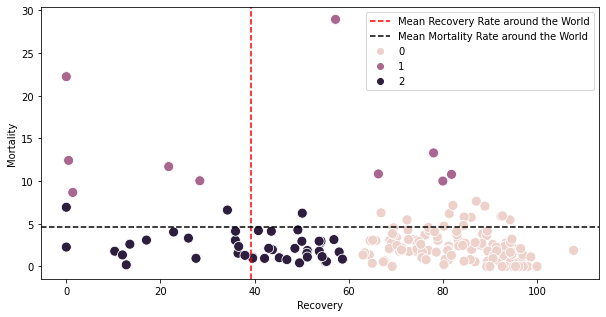

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=countrywise["Recovery"],y=countrywise["Mortality"],hue=countrywise["Clusters"],s=100)
plt.axvline(((datewise["Recovered"]/datewise["Confirmed"])*100).mean(),
            color='red',linestyle="--",label="Mean Recovery Rate around the World")
plt.axhline(((datewise["Deaths"]/datewise["Confirmed"])*100).mean(),
            color='black',linestyle="--",label="Mean Mortality Rate around the World")
plt.legend()

In [ ]:
cluster_0 = list(countrywise[countrywise["Clusters"]==0].head(10).index)
cluster_1 = list(countrywise[countrywise["Clusters"]==1].head(10).index)
cluster_2 = list(countrywise[countrywise["Clusters"]==2].head(10).index)

In [ ]:
print("Few Countries belonging to Cluster 0: ", cluster_0)
print("Few Countries belonging to Cluster 1: ", cluster_1)
print("Few Countries belonging to Cluster 2: ", cluster_2)

Few Countries belonging to Cluster 0:  ['Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia', 'Chile', 'Argentina', 'Iran', 'Saudi Arabia']
Few Countries belonging to Cluster 1:  ['Mexico', 'UK', 'France', 'Italy', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara', 'MS Zaandam']
Few Countries belonging to Cluster 2:  ['US', 'Spain', 'Ukraine', 'Bolivia', 'Romania', 'Sweden', 'Honduras', 'Ethiopia', 'Costa Rica', 'Nepal']


Action 2. K-means의 k값을 2에서부터 10까지 변경해가며 Within Cluster Sum of Squared를 Plotting 해본 결과 Elbow method로 k가 3일 때 가장 크게 감소하여 해당 값이 적정값으로 판단되었다. 


해당 결과를 토대로 Dendogram, DataFrame, Scatter plot 등으로 시각화하여 클러스터의 특징들을 살펴보았다. 그 결과 세 클러스터는 다음과 같았다.




```
Few Countries belonging to Cluster 0:  ['Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia', 'Chile', 'Argentina', 'Iran', 'Saudi Arabia']
Few Countries belonging to Cluster 1:  ['Mexico', 'UK', 'France', 'Italy', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara', 'MS Zaandam']
Few Countries belonging to Cluster 2:  ['US', 'Spain', 'Ukraine', 'Bolivia', 'Romania', 'Sweden', 'Honduras', 'Ethiopia', 'Costa Rica', 'Nepal']
```

이상치를 제외한 Recovery, Mortality 범위는 다음과 같다.
*   클러스터 0: Recovery [64.37, 94.91], Mean Recovery 83.75, Mortality [1.22, 5.74], Mean Mortality 2.25
*   클러스터 1: Recovery [0.0, 81.84], Mean Recovery 41.53, Mortality [8.67, 28.93], Mean Mortality 13.89
*   클러스터 2: Recovery [0.0, 57.97], Mean Recovery 39.50, Mortality [0.55, 6.93], Mean Mortality 2.36


각 클러스터를 분석해보면 클러스터 0의 경우, 높은 Recovery, 낮은 Mortality로 코로나에 대한 통제가 유효한 클러스터로 이해할 수 있다. 클러스터 1의 경우, 높은 Recovery와 높은 Mortality를 확인할 수 있다. 이 클러스터는 코로나 팬더믹 상황에서 치료를 통해 고군분토 중임을 확인 할 수 있다. 클러스터 2의 경우는 낮은 Recovery, 낮은 Mortality로 코로나 치료에 더욱 박차를 가할 필요가 있다.


다음으로 클러스터별로 다른 확진자수 예측 모델링을 통해 확진자수를 예측하고 그에 맞춘 백신 배포를 수행하기 위한 Actions을 수행토록 하겠다.



In [ ]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovered"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovered"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovered"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovered"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovered"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovered"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovered Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Death Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Mortality"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Mortality"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Mortality"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Mortality"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Mortality"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Mortality"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Mortality Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Mortality Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Recovery"]),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Recovery"]),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Recovery"]),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Recovery"]),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Recovery"]),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Recovery"]),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Recovery Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Recovery Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Confirmed"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Confirmed"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Confirmed"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Confirmed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_china.index, y=(datewise_china["Deaths"]).diff().fillna(0),
                    mode='lines',name="China"))
fig.add_trace(go.Scatter(x=datewise_Italy.index, y=(datewise_Italy["Deaths"]).diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US.index, y=(datewise_US["Deaths"]).diff().fillna(0),
                    mode='lines',name="United States"))
fig.add_trace(go.Scatter(x=datewise_Spain.index, y=(datewise_Spain["Deaths"]).diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_Brazil.index, y=(datewise_Brazil["Deaths"]).diff().fillna(0),
                    mode='lines',name="Brazil"))
fig.add_trace(go.Scatter(x=datewise_restofworld.index, y=(datewise_restofworld["Deaths"]).diff().fillna(0),
                    mode='lines',name="Rest of the World"))
fig.update_layout(title="Daily increase in Number of Death Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

A2. 
Action 1: 치명율과 회복율을 기반으로 국가별 클러스터링 수행 
Mortality Rate와 Recovery Rate를 기반으로 K-means Clustering의 Cluster 갯수를 Elbow Method로 탐색한 결과 3개의 Cluster가 WCSS가 가장 크게 감소하여 적정치로 확인되었다. 이를 토대로 3개의 Clsuter를 확인한 결과 다음과 같은 결과를 얻을 수 있었다.

```
# Clusters
Few Countries belonging to Cluster 0:  ['Mexico', 'UK', 'France', 'Italy', 'Belgium', 'Netherlands', 'Hungary', 'Yemen', 'Western Sahara', 'MS Zaandam']
Few Countries belonging to Cluster 1:  ['Brazil', 'India', 'Russia', 'Peru', 'South Africa', 'Colombia', 'Chile', 'Argentina', 'Iran', 'Saudi Arabia']
Few Countries belonging to Cluster 2:  ['US', 'Spain', 'Ukraine', 'Bolivia', 'Romania', 'Sweden', 'Honduras', 'Ethiopia', 'Costa Rica', 'Nepal']
```

Cluster 0의 경우, 낮은 Mortality Rate와 높은 Recovery Rate를 띄었다. 이를 토대로 해당 국가들은 코로나 통제가 가능한 국가로 추정할 수 있다.
Cluster 1의 경우, 낮은 Mortality Rate와 낮은 Recovery Rate를 띄었다. 해당 국가들 중 일부는 많은 감염자 수에 비해 낮은 Mortality를 보였지만 전반적으로 Recovery Rate를 높혀야하는 국가로 추정되었다.
Cluster 2의 경우, 높은 Mortality Rate와 높은 Recovery Rate를 나타냈다. 해당 국가들은 이미 많은 감염자가 발생하였지만 회복 중인 것으로 추정되었다.

Action 2: 클러스터별 다양한 감염자 예측 모델링을 통한 백신 수요 예측
다른 양상을 띄는 3가지의 클러스터별 감염자 예측 모델링을 다양한 방법론을 통해서 예측하고 성능을 비교하도록 하겠다. 




*   학습/테스트 데이터는 0.95, 0.05 비율로 나누도록 하겠다.
*   Linear, Polynomial, SVM, Holt, Holt's Winter, Auto Regression, Moving Average, ARIMA, SARIMA, Prophet의 성능을 비교하겠다.
*   성능 비교 Metric은 Root Mean Squared Error를 사용하겠다.




Action 3: 최적 모델 선정 및 백신 배포
선정된 모델을 통해 예상되는 감염자수에 맞게 마지막 단에 Softmax Function을 활용하여 클러스터 단위로 백신을 배포하는 방안을 수행토록 하겠다. 조금 더 세분한 배포를 위해서 클러스터 단위가 아닌 국가 단위의 감염자수 모델링 및 비교를 수행할 수 있으나 본 과제에서는 데모 차원에서 클러스터 단위로 아이디어 POC로 진행하도록 하겠다.

Prediction

Linear Regression Model for Confirm Cases Prediction

In [ ]:
cluster_data = dict()
cluster_data[0] = covid[covid["Country/Region"].isin(cluster_0)]
cluster_data[1] = covid[covid["Country/Region"].isin(cluster_1)]
cluster_data[2] = covid[covid["Country/Region"].isin(cluster_2)]

In [ ]:
datewise_cluster = dict()
for k in cluster_data.keys():
  datewise_cluster[k] = cluster_data[k].groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_world = covid.groupby(["ObservationDate"]).agg({"Confirmed": "sum", "Recovered": "sum", "Deaths": "sum"})

In [ ]:
fig=go.Figure()
for k in cluster_data.keys():
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=(datewise_cluster[k]["Confirmed"]),
                      mode='lines',name=f"Cluster_{k}"))
fig.add_trace(go.Scatter(x=datewise_world.index, y=(datewise_world["Confirmed"]),
                    mode='lines',name="World"))
fig.update_layout(title="Confirmed Cases plot",
                  xaxis_title="Date",yaxis_title="Number of Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
for k in datewise_cluster.keys():
  datewise_cluster[k]["Mortality"] = (datewise_cluster[k]["Deaths"]/datewise_cluster[k]["Confirmed"])*100
datewise_world["Mortality"]=(datewise_world["Deaths"]/datewise_world["Confirmed"])*100

In [ ]:
fig=go.Figure()
for k in datewise_cluster.keys():
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=(datewise_cluster[k]["Mortality"]),
                    mode='lines',name=f"Cluster {k}"))
fig.add_trace(go.Scatter(x=datewise_world.index, y=(datewise_world["Mortality"]),
                    mode='lines',name="World"))
fig.update_layout(title="Mortality Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Mortality Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

클러스터 0의 경우 2020년 5월 전까지 높은 사망율을 보이다가 안정화되는 것을 확인할 수 있었고 클러스터 1의 경우 2020년 5월 이후로 가장 높은 사망율을 보이는 것을 확인할 수 있다.

In [ ]:
for k in datewise_cluster.keys():
  datewise_cluster[k]["Recovery"] = (datewise_cluster[k]["Recovered"]/datewise_cluster[k]["Confirmed"])*100
datewise_world["Recovery"]=(datewise_world["Recovered"]/datewise_world["Confirmed"])*100

In [ ]:
fig=go.Figure()
for k in datewise_cluster.keys():
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=(datewise_cluster[k]["Recovery"]),
                           mode='lines',name=f"Cluster {k}"))
fig.add_trace(go.Scatter(x=datewise_world.index, y=(datewise_world["Recovery"]),
                    mode='lines',name="World"))
fig.update_layout(title="Recovery Rate comparison plot",
                  xaxis_title="Date",yaxis_title="Recovery Rate",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

2020년 중순부터 모든 클러스터에서 점차 회복율을 향상시키는 것을 확인할 수 있었다.

In [ ]:
for k in datewise_cluster.keys():
  print(f"Average growth factor of number of Confirmed Cases of Cluster {k}: {(datewise_cluster[k]['Confirmed']/datewise_cluster[k]['Confirmed'].shift()).mean()}")
  print(f"Median growth factor of number of Confirmed Cases of Cluster {k}: {(datewise_cluster[k]['Confirmed']/datewise_cluster[k]['Confirmed'].shift()).median()}")
print("Average growth factor of number of Confirmed Cases of World: ",(datewise_world["Confirmed"]/datewise_world["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases of World: ",(datewise_world["Confirmed"]/datewise_world["Confirmed"].shift()).median())

Average growth factor of number of Confirmed Cases of Cluster 0: inf
Median growth factor of number of Confirmed Cases of Cluster 0: 1.0369713327166894
Average growth factor of number of Confirmed Cases of Cluster 1: inf
Median growth factor of number of Confirmed Cases of Cluster 1: 1.0089410141603041
Average growth factor of number of Confirmed Cases of Cluster 2: 1.0837694134118914
Median growth factor of number of Confirmed Cases of Cluster 2: 1.0161328842438118
Average growth factor of number of Confirmed Cases of World:  1.0534037322997345
Median growth factor of number of Confirmed Cases of World:  1.0202013845748947


In [ ]:
fig=go.Figure()
for k in datewise_cluster.keys():
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=datewise_cluster[k]["Confirmed"]/datewise_cluster[k]["Confirmed"].shift(),
                    mode='lines',
                    name=f'Growth Factor of Confirmed Cases of Cluster {k}'))
fig.add_trace(go.Scatter(x=datewise_world.index, y=datewise_world["Confirmed"]/datewise_world["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases of World'))
fig.update_layout(title="Datewise Growth Factor of different Clusters",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Growth Factor는 전일대비 배수이므로 1 이상일 경우 감염자수가 지수적으로 증가한다고 판단할 수 있다. 데이터 분석 결과 2020년 6월까지 대체로 감염자수가 지수적으로 증가하다 이 후 안정화된다는 것을 확인할 수 있다.

In [ ]:
for k in datewise_cluster.keys():
  datewise_cluster[k]["Days Since"]=datewise_cluster[k].index-datewise_cluster[k].index[0]
  datewise_cluster[k]["Days Since"]=datewise_cluster[k]["Days Since"].dt.days

In [ ]:
train_ml = dict()
valid_ml = dict()
model_scores=dict({0: [], 1: [], 2: []})
for k in datewise_cluster.keys():
  train_ml[k] = datewise_cluster[k].iloc[:int(datewise_cluster[k].shape[0]*0.95)]
  valid_ml[k] = datewise_cluster[k].iloc[int(datewise_cluster[k].shape[0]*0.95):]


In [ ]:
lin_reg = dict()
for k in datewise_cluster.keys(): 
  lin_reg[k] = LinearRegression(normalize=True)

In [ ]:
for k in datewise_cluster.keys(): 
   lin_reg[k].fit(np.array(train_ml[k]["Days Since"]).reshape(-1,1), np.array(train_ml[k]["Confirmed"]).reshape(-1,1))

In [ ]:
prediction_valid_linreg = dict()
for k in datewise_cluster.keys(): 
  prediction_valid_linreg[k] = lin_reg[k].predict(np.array(valid_ml[k]["Days Since"]).reshape(-1,1))

In [ ]:
for k in datewise_cluster.keys():
  model_scores[k].append(np.sqrt(mean_squared_error(valid_ml[k]["Confirmed"],prediction_valid_linreg[k])))
  print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml[k]["Confirmed"],prediction_valid_linreg[k])))

Root Mean Square Error for Linear Regression:  4072133.7822905825
Root Mean Square Error for Linear Regression:  53055.419248360966
Root Mean Square Error for Linear Regression:  1582305.2586895663


In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Train Data for Confirmed Cases of Cluster 0", "Train Data for Confirmed Cases of Cluster 1", "Train Data for Confirmed Cases of Cluster 2"))

In [ ]:
prediction_linreg = dict()

fig = make_subplots(rows=3, cols=1, subplot_titles=("Train Data for Confirmed Cases of Cluster 0", "Train Data for Confirmed Cases of Cluster 1", "Train Data for Confirmed Cases of Cluster 2"))
for k in datewise_cluster.keys():
  prediction_linreg[k]=lin_reg[k].predict(np.array(datewise_cluster[k]["Days Since"]).reshape(-1,1))
  linreg_output=[]
  for i in range(prediction_linreg[k].shape[0]):
      linreg_output.append(prediction_linreg[k][i][0])

  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=datewise_cluster[k]["Confirmed"], name=f"Train Data for Confirmed Cases of Cluster {k}"), row=(k+1), col=1)
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=linreg_output, mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')), row=(k+1), col=1)
fig.update_layout(height=1000, width=1700, title="Confirmed Cases Linear Regression Prediction",
                xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

In [ ]:
poly = dict()
for k in datewise_cluster.keys():
  poly[k] = PolynomialFeatures(degree = 8)

In [ ]:
train_poly = dict()
valid_poly = dict()
y = dict()
for k in datewise_cluster.keys():
  train_poly[k]=poly[k].fit_transform(np.array(train_ml[k]["Days Since"]).reshape(-1,1))
  valid_poly[k]=poly[k].fit_transform(np.array(valid_ml[k]["Days Since"]).reshape(-1,1))
  y[k]=train_ml[k]["Confirmed"]

In [ ]:
linreg = dict()
for k in datewise_cluster.keys():
  linreg[k] = LinearRegression(normalize=True)
  linreg[k].fit(train_poly[k],y[k])

In [ ]:
prediction_poly = dict()
rmse_poly = dict()
for k in datewise_cluster.keys():
  prediction_poly[k]=linreg[k].predict(valid_poly[k])
  rmse_poly[k]=np.sqrt(mean_squared_error(valid_ml[k]["Confirmed"],prediction_poly[k]))
  model_scores[k].append(rmse_poly[k])
  print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly[k])

Root Mean Squared Error for Polynomial Regression:  172196.4708341155
Root Mean Squared Error for Polynomial Regression:  170192.2200239121
Root Mean Squared Error for Polynomial Regression:  38598.6277651914


In [ ]:
predictions_poly = dict()
comp_data = dict()

fig = make_subplots(rows=3, cols=1, subplot_titles=("Train Data for Confirmed Cases of Cluster 0", "Train Data for Confirmed Cases of Cluster 1", "Train Data for Confirmed Cases of Cluster 2"))
for k in datewise_cluster.keys():
  comp_data[k]=poly[k].fit_transform(np.array(datewise_cluster[k]["Days Since"]).reshape(-1,1))
  predictions_poly[k]=linreg[k].predict(comp_data[k])

  linreg_output=[]
  for i in range(prediction_linreg[k].shape[0]):
      linreg_output.append(prediction_linreg[k][i][0])

  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=datewise_cluster[k]["Confirmed"], name=f"Train Data for Confirmed Cases of Cluster {k}"), row=(k+1), col=1)
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=predictions_poly[k], mode='lines',name="Poly Regression Best Fit Line",
                    line=dict(color='black', dash='dot')), row=(k+1), col=1)
fig.update_layout(height=1000, width=1700, title="Confirmed Cases Polynomial Regression Prediction",
                xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

In [ ]:
new_prediction_poly = dict()

for k in datewise_cluster.keys():
  new_prediction_poly[k] = []
  for i in range(1,18):
      new_date_poly=poly[k].fit_transform(np.array(datewise_cluster[k]["Days Since"].max()+i).reshape(-1,1))
      new_prediction_poly[k].append(linreg[k].predict(new_date_poly)[0])

Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [ ]:
#Intializing SVR Model
svm = dict()
for k in datewise_cluster.keys():
  svm[k] = SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [ ]:
#Fitting model on the training data
for k in datewise_cluster.keys():
  svm[k].fit(np.array(train_ml[k]["Days Since"]).reshape(-1,1),np.array(train_ml[k]["Confirmed"]).reshape(-1,1))

In [ ]:
prediction_valid_svm = dict()
for k in datewise_cluster.keys():
  prediction_valid_svm[k] = svm[k].predict(np.array(valid_ml[k]["Days Since"]).reshape(-1,1))

In [ ]:
for k in datewise_cluster.keys():
  model_scores[k].append(np.sqrt(mean_squared_error(valid_ml[k]["Confirmed"],prediction_valid_svm[k])))
  print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml[k]["Confirmed"],prediction_valid_svm[k])))

Root Mean Square Error for Support Vectore Machine:  3952000.8829463487
Root Mean Square Error for Support Vectore Machine:  644854.7842217473
Root Mean Square Error for Support Vectore Machine:  2999947.9651803407


In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Train Data for Confirmed Cases of Cluster 0", "Train Data for Confirmed Cases of Cluster 1", "Train Data for Confirmed Cases of Cluster 2"))
prediction_svm = dict()
for k in datewise_cluster.keys():
  prediction_svm[k]=svm[k].predict(np.array(datewise_cluster[k]["Days Since"]).reshape(-1,1))

  linreg_output=[]
  for i in range(prediction_linreg[k].shape[0]):
      linreg_output.append(prediction_linreg[k][i][0])

  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=datewise_cluster[k]["Confirmed"], name=f"Train Data for Confirmed Cases of Cluster {k}"), row=(k+1), col=1)
  fig.add_trace(go.Scatter(x=datewise_cluster[k].index, y=prediction_svm[k], mode='lines',name="SVM Best Fit Line",
                    line=dict(color='black', dash='dot')), row=(k+1), col=1)
fig.update_layout(height=1000, width=1700, title="Confirmed Cases SVM Regression Prediction",
                xaxis_title="Date",yaxis_title="Confirmed Cases")
fig.show()

In [ ]:
new_date = []
new_prediction_lr = dict()
new_prediction_svm = dict()

for k in datewise_cluster.keys():
  new_date = []
  new_prediction_lr[k] = []
  new_prediction_svm[k] = []
  for i in range(1,18):
      new_date.append(datewise_cluster[k].index[-1]+timedelta(days=i))
      new_prediction_lr[k].append(lin_reg[k].predict(np.array(datewise_cluster[k]["Days Since"].max()+i).reshape(-1,1))[0][0])
      new_prediction_svm[k].append(svm[k].predict(np.array(datewise_cluster[k]["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date, *[lr for lr in new_prediction_lr.values()], *[npred for npred in new_prediction_poly.values()], *[npred_svm for npred_svm in new_prediction_svm.values()])
                              , columns=["Dates"
                              , "Linear Regression Prediction 0", "Linear Regression Prediction 1", "Linear Regression Prediction 2"
                              , "Polynonmial Regression Prediction 0", "Polynonmial Regression Prediction 1", "Polynonmial Regression Prediction 2"
                              , "SVM Prediction 0", "SVM Prediction 1", "SVM Prediction 2"
                              ])
model_predictions.head(50)

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279
5,2020-09-04,7379212.981004,1635700.797826,5426971.154080,11579175.680623,2460077.865657,7757219.845315,19893449.519016,2830201.856119,12750359.340536
6,2020-09-05,7422789.769699,1643943.999564,5456321.165344,11568038.281434,2568931.351925,7906962.799526,20424886.516578,2893051.536234,13068082.443161
7,2020-09-06,7466366.558395,1652187.201301,5485671.176608,11539210.648606,2687261.992690,8070809.364943,20968211.935828,2957307.184514,13392881.460176
8,2020-09-07,7509943.347090,1660430.403039,5515021.187871,11491309.475701,2815759.696368,8250244.112747,21523637.589909,3022993.850754,13724881.902411
9,2020-09-08,7553520.135786,1668673.604777,5544371.199135,11422877.056739,2955152.059664,8446853.815374,22091378.109810,3090136.918000,14064210.943054


Time Series Forecasting

In [ ]:
def data_prep():
  model_train = dict()
  valid = dict()
  y_pred = dict()
  for k in cluster_data.keys():
    model_train[k]=datewise_cluster[k].iloc[:int(datewise_cluster[k].shape[0]*0.95)]
    valid[k]=datewise_cluster[k].iloc[int(datewise_cluster[k].shape[0]*0.95):]
    y_pred[k]=valid[k].copy()
  return model_train, valid, y_pred

In [ ]:
def prediction(model, name):
  for k in datewise_cluster.keys():
    y_pred[k][name]=model[k].predict(len(valid[k])).to_list()

In [ ]:
def rmse(name, print_word):
  for k in datewise_cluster.keys():
    model_scores[k].append(np.sqrt(mean_squared_error(y_pred[k]["Confirmed"],y_pred[k][name])))
    print(f"Root Mean Square Error for {print_word} {k}: ",np.sqrt(mean_squared_error(y_pred[k]["Confirmed"],y_pred[k][name])))

In [ ]:
def plot_subs(nm, model_nm):
  fig = make_subplots(rows=3, cols=1, subplot_titles=("Train Data for Confirmed Cases of Cluster 0", "Train Data for Confirmed Cases of Cluster 1", "Train Data for Confirmed Cases of Cluster 2"))
  for k in datewise_cluster.keys():
    fig.add_trace(go.Scatter(x=model_train[k].index, y=model_train[k]["Confirmed"],
                    mode='lines+markers',name=f"Train Data for Confirmed Cases {k}"), row=(k+1), col=1)
    fig.add_trace(go.Scatter(x=valid[k].index, y=valid[k]["Confirmed"],
                        mode='lines+markers',name=f"Validation Data for Confirmed Cases {k}",), row=(k+1), col=1)
    fig.add_trace(go.Scatter(x=valid[k].index, y=y_pred[k][model_nm],
                        mode='lines+markers',name=f"Prediction of Confirmed Cases {k}",), row=(k+1), col=1)
  fig.update_layout(height=1000, width=1700, title=nm,
                  xaxis_title="Date",yaxis_title="Confirmed Cases")
  fig.show()

In [ ]:
def compare_model(model, model_nm):
  model_new_prediction = dict()
  for k in datewise_cluster.keys():
    model_new_prediction = []
    for i in range(1,18):
        model_new_prediction.append(model[k].predict(len(valid[k])+i).iloc[-1])
    model_predictions[f"{model_nm} {k}"]=model_new_prediction

Holt's Linear Model

In [ ]:
model_train, valid, y_pred = data_prep()

In [ ]:
holt = dict()
for k in cluster_data.keys():
  holt[k]=Holt(np.asarray(model_train[k]["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)    

In [ ]:
for k in cluster_data.keys():
  y_pred[k]["Holt"]=holt[k].forecast(len(valid[k]))

rmse("Holt", "Holt's Linear Model")

Root Mean Square Error for Holt's Linear Model 0:  65137.6172938046
Root Mean Square Error for Holt's Linear Model 1:  16956.91029264724
Root Mean Square Error for Holt's Linear Model 2:  26597.340388741886


In [ ]:
plot_subs("Holt's Linear Model Prediction", "Holt")

In [ ]:
holt_new_date = dict()
holt_new_prediction = dict()
for k in datewise_cluster.keys():
  holt_new_date[k] = []
  holt_new_prediction[k] = []
  for i in range(1,18):
      holt_new_date[k].append(datewise_cluster[k].index[-1]+timedelta(days=i))
      holt_new_prediction[k].append(holt[k].forecast((len(valid[k])+i))[-1])

  model_predictions[f"Holt's Linear Model Prediction {k}"]=holt_new_prediction[k]
model_predictions.head()

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,Holt's Linear Model Prediction 0,Holt's Linear Model Prediction 1,Holt's Linear Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,11724353.314927,1644769.203225,7087941.989348
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,11860848.158070,1655220.802655,7148797.722488
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,11997343.001213,1665672.402085,7209653.455627
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,12133837.844355,1676124.001515,7270509.188766
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,12270332.687498,1686575.600944,7331364.921906


Holt's Winter Model for Daily Time Series

In [ ]:
es = dict()
for k in datewise_cluster.keys(): 
  es[k]=ExponentialSmoothing(np.asarray(model_train[k]['Confirmed'])[1:],seasonal_periods=14,trend='add', seasonal='mul').fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
for k in datewise_cluster.keys(): 
  y_pred[k]["Holt's Winter Model"] = es[k].forecast(len(valid[k])) 

rmse("Holt's Winter Model", "Holt's Winter Model")

Root Mean Square Error for Holt's Winter Model 0:  132466.9053422387
Root Mean Square Error for Holt's Winter Model 1:  12942.11736726255
Root Mean Square Error for Holt's Winter Model 2:  35601.326559838984


In [ ]:
plot_subs("Confirmed Cases Holt's Winter Model Prediction", "Holt\'s Winter Model")

In [ ]:
holt_winter_new_prediction = dict()
for k in datewise_cluster.keys():
  holt_winter_new_prediction[k] = []
  for i in range(1,18):
      holt_winter_new_prediction[k].append(es[k].forecast((len(valid[k])+i))[-1])
  model_predictions[f"Holt's Winter Model Prediction {k}"]=holt_winter_new_prediction[k]
model_predictions.head()

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,Holt's Linear Model Prediction 0,Holt's Linear Model Prediction 1,Holt's Linear Model Prediction 2,Holt's Winter Model Prediction 0,Holt's Winter Model Prediction 1,Holt's Winter Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,11724353.314927,1644769.203225,7087941.989348,11812632.065385,1679562.944368,7095906.558756
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,11860848.158070,1655220.802655,7148797.722488,11945915.343226,1686666.649716,7146323.561478
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,11997343.001213,1665672.402085,7209653.455627,12244257.348276,1697787.674973,7205605.084606
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,12133837.844355,1676124.001515,7270509.188766,12457822.757496,1711204.899198,7262060.561798
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,12270332.687498,1686575.600944,7331364.921906,12652456.878992,1729709.210304,7327560.180383


AR Model (using AUTO ARIMA)

In [ ]:
model_ar = dict()
for k in datewise_cluster.keys():
  model_ar[k] = auto_arima(model_train[k]["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                    suppress_warnings=True,stepwise=False,seasonal=False)
  model_ar[k].fit(model_train[k]["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4464.361, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4411.423, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4412.805, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4395.472, Time=0.23 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4368.194, Time=0.45 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.871 seconds
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4068.000, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4026.066, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=3989.578, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=3982.433, Time=0.28 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=3978.345, Time=0.36 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 1.124 seconds
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4144.023, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4136.280, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4134.620, Ti

In [ ]:
for k in datewise_cluster.keys():
  y_pred[k]["AR Model Prediction"]=model_ar[k].predict(len(valid[k])).to_list()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
rmse("AR Model Prediction", "AR Model")

Root Mean Square Error for AR Model 0:  17070.060275558568
Root Mean Square Error for AR Model 1:  25208.808644425913
Root Mean Square Error for AR Model 2:  30763.814978492974


In [ ]:
plot_subs("Confirmed Cases AR Model Prediction", "AR Model Prediction")

In [ ]:
compare_model(model_ar, "AR Model Prediction")
model_predictions.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beg

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,Holt's Linear Model Prediction 0,Holt's Linear Model Prediction 1,Holt's Linear Model Prediction 2,Holt's Winter Model Prediction 0,Holt's Winter Model Prediction 1,Holt's Winter Model Prediction 2,AR Model Prediction 0,AR Model Prediction 1,AR Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,11724353.314927,1644769.203225,7087941.989348,11812632.065385,1679562.944368,7095906.558756,11836154.506123,1631900.268334,7104939.568293
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,11860848.158070,1655220.802655,7148797.722488,11945915.343226,1686666.649716,7146323.561478,11988381.182946,1641775.263646,7169548.878263
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,11997343.001213,1665672.402085,7209653.455627,12244257.348276,1697787.674973,7205605.084606,12141132.634790,1651705.006284,7234402.430139
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,12133837.844355,1676124.001515,7270509.188766,12457822.757496,1711204.899198,7262060.561798,12293159.728765,1661681.365668,7299531.410084
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,12270332.687498,1686575.600944,7331364.921906,12652456.878992,1729709.210304,7327560.180383,12445215.651548,1671699.078743,7364970.538749


MA Model (using AUTO ARIMA)

In [ ]:
model_ma = dict()
for k in datewise_cluster.keys():
  model_ma[k]= auto_arima(model_train[k]["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                    suppress_warnings=True,stepwise=False,seasonal=False)
  model_ma[k].fit(model_train[k]["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4464.361, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4382.469, Time=0.88 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4414.366, Time=0.20 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 1.138 seconds
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4068.000, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3974.821, Time=0.14 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=3975.074, Time=0.56 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.770 seconds
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4144.023, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4131.096, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4126.972, Time=0.33 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 0.595 seconds


In [ ]:
for k in datewise_cluster.keys():
  y_pred[k]["MA Model Prediction"]=model_ma[k].predict(len(valid[k])).to_list()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
rmse("MA Model Prediction", "MA Model")

Root Mean Square Error for MA Model 0:  19759.71639987636
Root Mean Square Error for MA Model 1:  18251.79517326077
Root Mean Square Error for MA Model 2:  32237.5511178299


In [ ]:
plot_subs("Confirmed Cases MA Model Prediction", "MA Model Prediction")

In [ ]:
compare_model(model_ma, "MA Model Prediction")
model_predictions.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beg

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,...,Holt's Linear Model Prediction 2,Holt's Winter Model Prediction 0,Holt's Winter Model Prediction 1,Holt's Winter Model Prediction 2,AR Model Prediction 0,AR Model Prediction 1,AR Model Prediction 2,MA Model Prediction 0,MA Model Prediction 1,MA Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,...,7087941.989348,11812632.065385,1679562.944368,7095906.558756,11836154.506123,1631900.268334,7104939.568293,11847660.741639,1646136.259246,7116010.370557
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,...,7148797.722488,11945915.343226,1686666.649716,7146323.561478,11988381.182946,1641775.263646,7169548.878263,12000362.981125,1657685.080486,7183896.050531
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,...,7209653.455627,12244257.348276,1697787.674973,7205605.084606,12141132.634790,1651705.006284,7234402.430139,12153788.132561,1669341.217054,7252390.247170
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,...,7270509.188766,12457822.757496,1711204.899198,7262060.561798,12293159.728765,1661681.365668,7299531.410084,12307936.195949,1681104.668951,7321492.960474
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,...,7331364.921906,12652456.878992,1729709.210304,7327560.180383,12445215.651548,1671699.078743,7364970.538749,12462807.171288,1692975.436177,7391204.190443


ARIMA Model (using AUTOARIMA)

In [ ]:
model_arima = dict()
for k in datewise_cluster.keys():
  model_arima[k]= auto_arima(model_train[k]["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                    suppress_warnings=True,stepwise=False,seasonal=False)
  model_arima[k].fit(model_train[k]["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4464.361, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=4382.469, Time=0.62 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=4414.366, Time=0.21 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=4451.080, Time=0.32 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4411.423, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=4410.802, Time=0.19 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=4381.491, Time=1.73 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=4415.004, Time=0.49 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4412.805, Time=0.12 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=4395.164, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4395.472, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=4346.922, Time=0.43 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=4331.743, Time=1.55 sec

Best model:  ARIMA(

In [ ]:
for k in datewise_cluster.keys():
  y_pred[k]["ARIMA Model Prediction"]=model_arima[k].predict(len(valid[k])).to_list()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
rmse("ARIMA Model Prediction", "ARIMA Model")

Root Mean Square Error for ARIMA Model 0:  114697.03368173145
Root Mean Square Error for ARIMA Model 1:  21333.827558954523
Root Mean Square Error for ARIMA Model 2:  66209.50448062427


In [ ]:
plot_subs("Confirmed Cases ARIMA Model Prediction", "ARIMA Model Prediction")

In [ ]:
compare_model(model_arima, "ARIMA Model Prediction")
model_predictions.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beg

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,...,Holt's Winter Model Prediction 2,AR Model Prediction 0,AR Model Prediction 1,AR Model Prediction 2,MA Model Prediction 0,MA Model Prediction 1,MA Model Prediction 2,ARIMA Model Prediction 0,ARIMA Model Prediction 1,ARIMA Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,...,7095906.558756,11836154.506123,1631900.268334,7104939.568293,11847660.741639,1646136.259246,7116010.370557,12076123.433539,1638496.277642,7172769.618153
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,...,7146323.561478,11988381.182946,1641775.263646,7169548.878263,12000362.981125,1657685.080486,7183896.050531,12236523.930037,1648874.695073,7239483.542971
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,...,7205605.084606,12141132.634790,1651705.006284,7234402.430139,12153788.132561,1669341.217054,7252390.247170,12418091.853564,1659299.216904,7312329.590204
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,...,7262060.561798,12293159.728765,1661681.365668,7299531.410084,12307936.195949,1681104.668951,7321492.960474,12623639.308198,1669769.843135,7391611.823121
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,...,7327560.180383,12445215.651548,1671699.078743,7364970.538749,12462807.171288,1692975.436177,7391204.190443,12840945.330809,1680286.573767,7473227.835905


SARIMA Model (using AUTO ARIMA)

In [ ]:
model_sarima = dict()
for k in datewise_cluster.keys():
  model_sarima[k]= auto_arima(model_train[k]["Confirmed"],trace=True, error_action='ignore', 
                          start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                    suppress_warnings=True,stepwise=True,seasonal=True)
  model_sarima[k].fit(model_train[k]["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=4450.995, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=4462.807, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=4331.200, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=4372.305, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=4410.489, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=4332.015, Time=0.22 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=4329.866, Time=0.25 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=4361.362, Time=0.16 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=4328.926, Time=0.72 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=4329.710, Time=0.72 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=4327.766, Time=0.54 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=4345.473, Time=0.27 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=4458.692, Time=0.52 sec
 ARIMA(2,2,0)(1,0,2)[7]             : AIC=4326.378, Time=0.62 sec
 ARIMA(2,2,0)(0,0,2)[7]          

In [ ]:
prediction_sarima = dict()
for k in datewise_cluster.keys():
  y_pred[k]["SARIMA Model Prediction"]=model_sarima[k].predict(len(valid[k])).to_list()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
rmse("SARIMA Model Prediction", "SARIMA Model")

Root Mean Square Error for SARIMA Model 0:  19928.212909738206
Root Mean Square Error for SARIMA Model 1:  23749.94618676529
Root Mean Square Error for SARIMA Model 2:  10502.457862741967


In [ ]:
plot_subs("Confirmed Cases SARIMA Model Prediction", "SARIMA Model Prediction")

In [ ]:
compare_model(model_sarima, "SARIMA Model Prediction")
model_predictions.head()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beg

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,...,AR Model Prediction 2,MA Model Prediction 0,MA Model Prediction 1,MA Model Prediction 2,ARIMA Model Prediction 0,ARIMA Model Prediction 1,ARIMA Model Prediction 2,SARIMA Model Prediction 0,SARIMA Model Prediction 1,SARIMA Model Prediction 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,...,7104939.568293,11847660.741639,1646136.259246,7116010.370557,12076123.433539,1638496.277642,7172769.618153,11861787.303220,1634076.200568,7048975.705606
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,...,7169548.878263,12000362.981125,1657685.080486,7183896.050531,12236523.930037,1648874.695073,7239483.542971,11981469.707670,1643922.467282,7103196.553739
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,...,7234402.430139,12153788.132561,1669341.217054,7252390.247170,12418091.853564,1659299.216904,7312329.590204,12130853.314803,1653768.733996,7158331.367548
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,...,7299531.410084,12307936.195949,1681104.668951,7321492.960474,12623639.308198,1669769.843135,7391611.823121,12297175.486343,1663615.000710,7216158.143179
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,...,7364970.538749,12462807.171288,1692975.436177,7391204.190443,12840945.330809,1680286.573767,7473227.835905,12460561.278785,1673461.267424,7276290.136021


Facebook's Prophet Model for forecasting

In [ ]:
prophet_c = dict()
prophet_confirmed = dict()
for k in datewise_cluster.keys():
  prophet_c[k]=Prophet(interval_width=0.95,weekly_seasonality=True,)
  prophet_confirmed[k]=pd.DataFrame(zip(list(train_ml[k].index),list(train_ml[k]["Confirmed"])),columns=['ds','y'])

In [ ]:
for k in datewise_cluster.keys(): 
  prophet_c[k].fit(prophet_confirmed[k])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d9h5z07/w6rp5nmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6d9h5z07/45eylbw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61964', 'data', 'file=/tmp/tmp6d9h5z07/w6rp5nmu.json', 'init=/tmp/tmp6d9h5z07/45eylbw_.json', 'output', 'file=/tmp/tmp6d9h5z07/prophet_modellxzi97yi/prophet_model-20230115222159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

In [ ]:
forecast_c = dict()
forecast_confirmed = dict()
for k in datewise_cluster.keys(): 
  forecast_c[k]=prophet_c[k].make_future_dataframe(periods=12)
  forecast_confirmed[k]=forecast_c[k].copy()

In [ ]:
confirmed_forecast = dict()
for k in datewise_cluster.keys(): 
  confirmed_forecast[k]=prophet_c[k].predict(forecast_c[k])
  y_pred[k]['prophet'] = confirmed_forecast[k]['yhat'].iloc[-12:].to_list() if k == 2 else confirmed_forecast[k]['yhat'].iloc[-11:].to_list()

In [ ]:
confirmed_forecast[0]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-23,-5948.964090,-100489.315304,88990.988501,-5948.964090,-5948.964090,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,0.000000,0.000000,0.000000,-4730.510460
1,2020-01-30,-4128.866743,-104252.125148,86770.439335,-4128.866743,-4128.866743,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,0.000000,0.000000,0.000000,-2910.413113
2,2020-01-31,-3868.852836,-86462.782842,93083.600479,-3868.852836,-3868.852836,5973.955609,5973.955609,5973.955609,5973.955609,5973.955609,5973.955609,0.000000,0.000000,0.000000,2105.102773
3,2020-02-01,-3608.838929,-92828.749875,96656.552626,-3608.838929,-3608.838929,6146.108332,6146.108332,6146.108332,6146.108332,6146.108332,6146.108332,0.000000,0.000000,0.000000,2537.269403
4,2020-02-02,-3348.825023,-91963.283816,84658.204263,-3348.825023,-3348.825023,2445.052578,2445.052578,2445.052578,2445.052578,2445.052578,2445.052578,0.000000,0.000000,0.000000,-903.772445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2020-08-25,10869130.366766,10746813.532453,10966900.108410,10796515.930376,10922183.461736,-6445.109765,-6445.109765,-6445.109765,-6445.109765,-6445.109765,-6445.109765,0.000000,0.000000,0.000000,10862685.257001
210,2020-08-26,11000859.830796,10883894.680773,11112322.268336,10914492.688213,11068915.042578,-3267.408669,-3267.408669,-3267.408669,-3267.408669,-3267.408669,-3267.408669,0.000000,0.000000,0.000000,10997592.422127
211,2020-08-27,11132589.294827,11003768.675942,11255046.489516,11032993.824801,11214674.280958,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,1218.453630,0.000000,0.000000,0.000000,11133807.748457
212,2020-08-28,11264318.758858,11126164.309158,11394773.705155,11155267.492466,11357354.593298,5973.955609,5973.955609,5973.955609,5973.955609,5973.955609,5973.955609,0.000000,0.000000,0.000000,11270292.714466


In [ ]:
for k in datewise_cluster.keys():
  gt = datewise_cluster[k]["Confirmed"][1:] if k == 2 else datewise_cluster[k]["Confirmed"]
  model_scores[k].append(np.sqrt(mean_squared_error(gt, confirmed_forecast[k]['yhat'].head(datewise_cluster[k].shape[0]))))
  print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(gt,confirmed_forecast[k]['yhat'].head(datewise_cluster[k].shape[0]))))

Root Mean Squared Error for Prophet Model:  69447.11910624098
Root Mean Squared Error for Prophet Model:  9009.409408485728
Root Mean Squared Error for Prophet Model:  43954.19326513797


Figure(720x432)
Figure(720x432)
Figure(720x432)


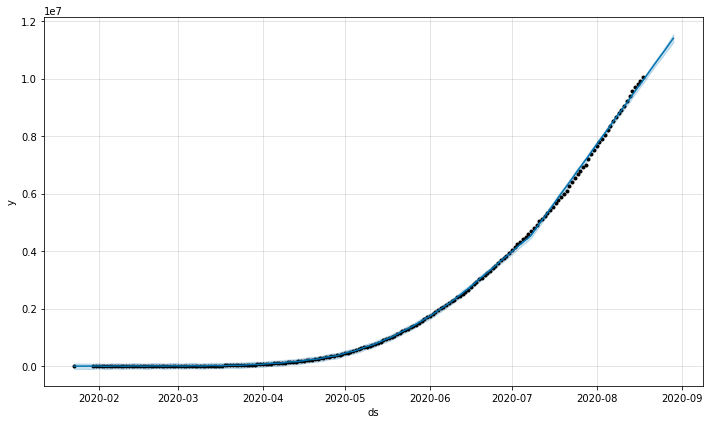

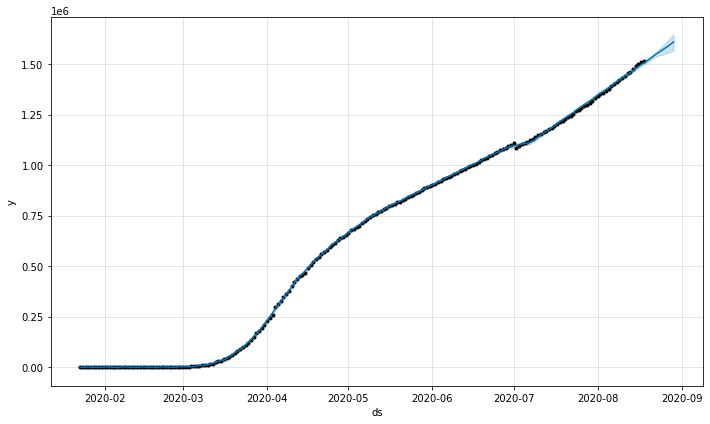

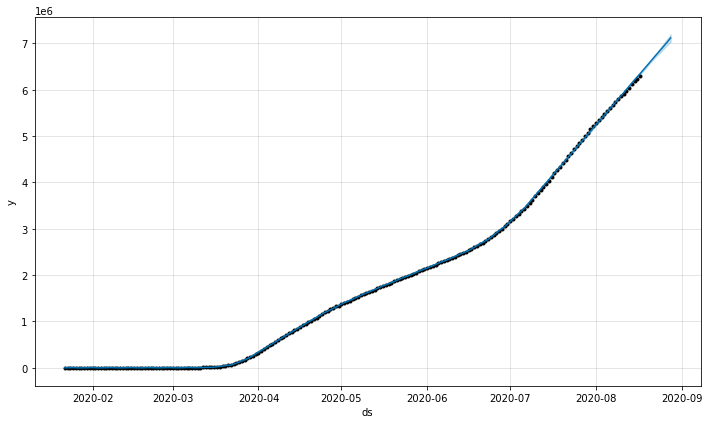

In [ ]:
for k in datewise_cluster.keys(): 
  print(prophet_c[k].plot(confirmed_forecast[k]))

Figure(648x432)
Figure(648x432)
Figure(648x432)


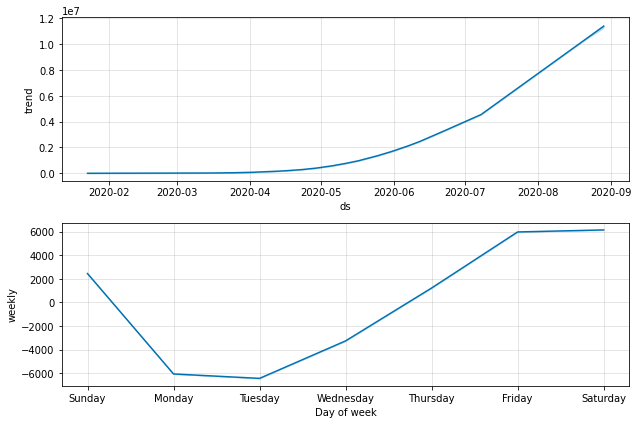

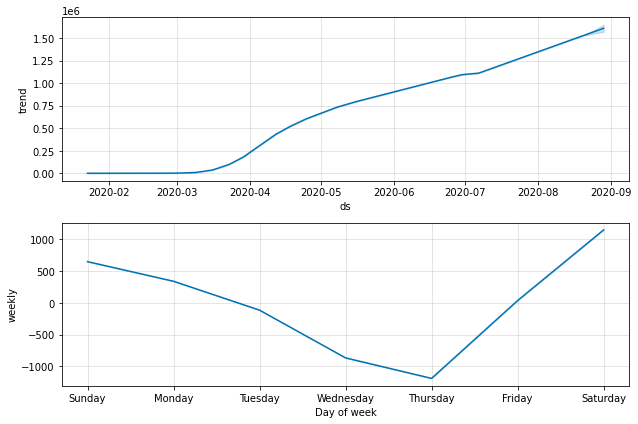

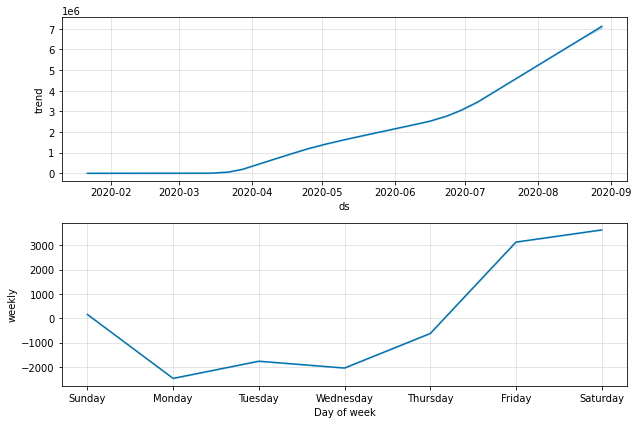

In [ ]:
for k in datewise_cluster.keys(): 
  print(prophet_c[k].plot_components(confirmed_forecast[k]))

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores[0]),columns=["Model Name","Root Mean Squared Error of Cluster 0"]).sort_values(["Root Mean Squared Error of Cluster 0"])
model_summary

,Model Name,Root Mean Squared Error of Cluster 0
5,Auto Regressive Model (AR),17070.060276
6,Moving Average Model (MA),19759.716400
8,SARIMA Model,19928.212910
3,Holt's Linear,65137.617294
9,Facebook's Prophet Model,69447.119106
7,ARIMA Model,114697.033682
4,Holt's Winter Model,132466.905342
1,Polynomial Regression,172196.470834
2,Support Vector Machine Regressor,3952000.882946
0,Linear Regression,4072133.782291


In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores[1]),columns=["Model Name","Root Mean Squared Error of Cluster 1"]).sort_values(["Root Mean Squared Error of Cluster 1"])
model_summary

,Model Name,Root Mean Squared Error of Cluster 1
9,Facebook's Prophet Model,9009.409408
4,Holt's Winter Model,12942.117367
3,Holt's Linear,16956.910293
6,Moving Average Model (MA),18251.795173
7,ARIMA Model,21333.827559
8,SARIMA Model,23749.946187
5,Auto Regressive Model (AR),25208.808644
0,Linear Regression,53055.419248
1,Polynomial Regression,170192.220024
2,Support Vector Machine Regressor,644854.784222


In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores[2]),columns=["Model Name","Root Mean Squared Error of Cluster 2"]).sort_values(["Root Mean Squared Error of Cluster 2"])
model_summary

,Model Name,Root Mean Squared Error of Cluster 2
8,SARIMA Model,10502.457863
3,Holt's Linear,26597.340389
5,Auto Regressive Model (AR),30763.814978
6,Moving Average Model (MA),32237.551118
4,Holt's Winter Model,35601.326560
1,Polynomial Regression,38598.627765
9,Facebook's Prophet Model,43954.193265
7,ARIMA Model,66209.504481
0,Linear Regression,1582305.258690
2,Support Vector Machine Regressor,2999947.965180


In [ ]:
model_predictions.shape

(17, 28)

In [ ]:
for k in datewise_cluster.keys(): 
  model_predictions[f"Prophet's Prediction of Cluster {k}"]=list(confirmed_forecast[k]["yhat"].tail(17))
  model_predictions[f"Prophet's Upper Bound of Cluster {k}"]=list(confirmed_forecast[k]["yhat_upper"].tail(17))
model_predictions.head()

,Dates,Linear Regression Prediction 0,Linear Regression Prediction 1,Linear Regression Prediction 2,Polynonmial Regression Prediction 0,Polynonmial Regression Prediction 1,Polynonmial Regression Prediction 2,SVM Prediction 0,SVM Prediction 1,SVM Prediction 2,...,ARIMA Model Prediction 2,SARIMA Model Prediction 0,SARIMA Model Prediction 1,SARIMA Model Prediction 2,Prophet's Prediction of Cluster 0,Prophet's Upper Bound of Cluster 0,Prophet's Prediction of Cluster 1,Prophet's Upper Bound of Cluster 1,Prophet's Prediction of Cluster 2,Prophet's Upper Bound of Cluster 2
0,2020-08-30,7161329.037526,1594484.789137,5280221.097761,11413066.791627,2036280.320423,7174694.572461,17407371.533930,2536189.194561,11263604.201325,...,7172769.618153,11861787.303220,1634076.200568,7048975.705606,9289595.252028,9391116.889726,1457184.445900,1464990.597185,6004723.801550,6031364.148573
1,2020-08-31,7204905.826222,1602727.990875,5309571.109025,11472041.277595,2106876.559024,7272920.189410,17882446.723372,2592373.321417,11547773.226849,...,7239483.542971,11981469.707670,1643922.467282,7103196.553739,9426080.218037,9512628.737847,1467795.615837,1474986.926465,6075496.196951,6099151.911257
2,2020-09-01,7248482.614917,1610971.192613,5338921.120289,11519222.382374,2184016.504974,7379205.903689,18368392.673337,2649843.064112,11838415.040966,...,7312329.590204,12130853.314803,1653768.733996,7158331.367548,9557981.834791,9661033.181121,1478293.648216,1485618.849137,6148606.633207,6172867.571777
3,2020-09-02,7292059.403613,1619214.394350,5368271.131553,11553557.891525,2268222.534943,7494590.486459,18865407.477115,2708621.849882,12135647.059690,...,7391611.823121,12297175.486343,1663615.000710,7216158.143179,9686010.243068,9779999.480756,1487183.843088,1495308.974492,6218458.576790,6241915.885658
4,2020-09-03,7335636.192308,1627457.596088,5397621.142816,11573934.579942,2360047.869106,7620193.609127,19373691.923079,2768733.424693,12439588.289279,...,7473227.835905,12460561.278785,1673461.267424,7276290.136021,9809223.602806,9898124.468454,1496264.328446,1503993.619847,6284336.835904,6310119.601409


Action 3. 클러스터별 확진자수/감염자수에 대하여 다양한 예측 모델링을 수행하였고 그 결과를 살펴보았다.


실험데이터 정보는 다음과 같다.
*   데이터 날짜 단위: 일
*   학습데이터 수: 214(일)
*   테스트데이터 수: 11(일)
*   특징: 확진자수
*   학습데이터 시계열 범위: [2020-01-23, 2020-08-18]
*   테스트 데이터 시계열 범위: [2020-08-19, 2020-08-29]
*   모델: Days Since 모델들 제외한 모델들.


RMSE를 Metric으로 TOP 5 랭킹을 확인한 결과 클러스터 0에서는 AR, MA, SARIMA, Holt, Prophet 순으로 나타났다. 클러스터 1에서는 Prophet, Holt's Winter, Holt, MA, ARIMA 순이었다. 클러스터 2에서는 SARIMA, Holt, AR, MA, Holt's Winter 순이었다.

In [ ]:
def softmax(vector):
  normalized_vector = normalize([vector])
  e = np.exp(normalized_vector)
  return e / e.sum()

In [ ]:
print(y_pred[0]["SARIMA Model Prediction"].sum())

120748687.77077575


In [ ]:
model_nms = ['Holt', "Holt's Winter Model", 'AR Model Prediction', 'MA Model Prediction', 'ARIMA Model Prediction', 'SARIMA Model Prediction', 'prophet']

In [ ]:
confirmed_cluster_pred = dict()
for model_nm in model_nms:
  confirmed_cluster_sum = []
  for k in datewise_cluster.keys():
    confirmed_cluster_sum.append(y_pred[k][model_nm].sum())
  confirmed_cluster_pred[model_nm] = softmax(confirmed_cluster_sum)[0]

In [ ]:
Res = pd.DataFrame(confirmed_cluster_pred).transpose()
Res

,0,1,2
Holt,0.443404,0.219020,0.337576
Holt's Winter Model,0.444735,0.219223,0.336042
AR Model Prediction,0.444004,0.218852,0.337144
MA Model Prediction,0.443940,0.218937,0.337123
ARIMA Model Prediction,0.444653,0.218748,0.336599
SARIMA Model Prediction,0.444557,0.218868,0.336575
prophet,0.440834,0.218851,0.340315


Action 4.


테스트 환경
*   테스트 데이터 범위: [2020-08-19 + 60, 2020-08-29 + 60]
*   예측값: 확진자수/감염자수
*   예측 모델: ['Holt', "Holt's Winter Model", 'AR Model Prediction', 'MA Model Prediction', 'ARIMA Model Prediction', 'SARIMA Model Prediction', 'prophet']


클러스터별로 예측 범위 내 확진자수의 총합을 구하여 백신 수요량을 추정하고 추정된 값의 비율을 Softmax를 통해 계산하였다. 그 결과 클러스터 0의 경우 전체 확진자수의 43%를 차지했고 클러스터 1의 경우 22%를 차지했다. 클러스터 2의 경우는 나머지 34%의 비중을 차지했다. 이를 통해 각 클러스터의 비중에 맞춰 백신을 배포하여 수요를 충족시키는 것이 합리적이라고 판단된다.

A4. 본 테스크에서 수행한 시간 대비 2달 (대략 60일) 이후의 시점에 대한 각 모델들의 추정치는 다음과 같다.

In [ ]:
confirmed_cluster_pred_2m = {0: dict(), 1: dict(), 2: dict()}
for k in cluster_data.keys():
  confirmed_cluster_pred_2m[k]['Holt'] = holt[k].forecast(len(valid[k]) + 60)[-11:].sum()
  confirmed_cluster_pred_2m[k]["Holt's Winter Model"] = es[k].forecast(len(valid[k]) + 60)[-11:].sum()
  confirmed_cluster_pred_2m[k]["AR Model Prediction"] = np.sum(model_ar[k].predict(len(valid[k]) + 60).to_list()[-11:])
  confirmed_cluster_pred_2m[k]["MA Model Prediction"] = np.sum(model_ma[k].predict(len(valid[k]) + 60).to_list()[-11:])
  confirmed_cluster_pred_2m[k]["ARIMA Model Prediction"] = np.sum(model_arima[k].predict(len(valid[k]) + 60).to_list()[-11:])
  confirmed_cluster_pred_2m[k]["SARIMA Model Prediction"] = np.sum(model_sarima[k].predict(len(valid[k]) + 60).to_list()[-11:])
  forecast_copy = forecast_c[k].copy()
  ds = pd.concat([forecast_copy, pd.DataFrame(pd.date_range(forecast_copy['ds'].iloc[-1], periods=60, freq='D'), columns=['ds'])], ignore_index=True)
  confirmed_cluster_pred_2m[k]["prophet"] = np.sum(prophet_c[k].predict(ds)['yhat'].iloc[-11:].to_list())


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
pred_2m_ahead_rate = dict()
for key, row in pd.DataFrame(confirmed_cluster_pred_2m).iterrows():
  pred_2m_ahead_rate[key] = dict({0: softmax(row)[0][0], 1: softmax(row)[0][1], 2: softmax(row)[0][2]}) 
pd.DataFrame(pred_2m_ahead_rate).transpose()

,0,1,2
Holt,0.468950,0.216468,0.314582
Holt's Winter Model,0.470712,0.217538,0.311750
AR Model Prediction,0.473411,0.215282,0.311307
MA Model Prediction,0.467510,0.216179,0.316312
ARIMA Model Prediction,0.486577,0.213229,0.300194
SARIMA Model Prediction,0.481062,0.216121,0.302816
prophet,0.461037,0.215571,0.323392


2달 후 클러스터별 비중의 차이가 11일 후 보다 커진 것을 확인할 수 있다. 이는 대부분의 시계열 모델이 예측하는 길이가 길어질수록 정확도가 떨어지기 때문으로 추정된다. 시계열 모델의 정확도를 확인하기 위해서는 2달 뒤 실측 데이터를 관측하여 차이를 확인하는 수 밖에 없다. 실제 데이터와 차이가 클 경우 시계열 정보 외에 확진자수에 영향을 미치는 주요 특징들이 존재한다고 추정할 수 있다.